<a href="https://colab.research.google.com/github/RahafAlatiq0/CCTV_violence_detection/blob/main/Violence_Detection_YoloV8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Import Packages

In [1]:
!pip install onnx>=1.12.0 --quiet

In [2]:
!pip install ultralytics --quiet
!pip install roboflow --quiet
!pip uninstall -y pycocotools --quiet
!pip install pycocotools --no-binary pycocotools --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 617.0/617.0 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 842.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from ultralytics import YOLO
from IPython.display import display, Image
from roboflow import Roboflow

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.6/78.2 GB disk)


In [4]:
HOME = os.getcwd()
print(HOME)

/content


## 2. Import dataset

In [5]:
!mkdir {HOME}/yolo_datasets
%cd {HOME}/yolo_datasets

/content/yolo_datasets


In [6]:
rf = Roboflow(api_key="qJLUbHOVjdzVuM0S1s0M")
project = rf.workspace('rahaf-5yhgj').project("violence-vvzjv")
dataset = project.version(1).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.180, to fix: `pip install ultralytics==8.0.134`
Exporting format yolov8 in progress : 85.0%
Version export complete for yolov8 format



Extracting Dataset Version Zip to violence-1 in yolov8:: 100%|██████████| 7822/7822 [00:01<00:00, 6897.10it/s]


## 3. Exploratory Data Analysis

### A. Object Count Analysis

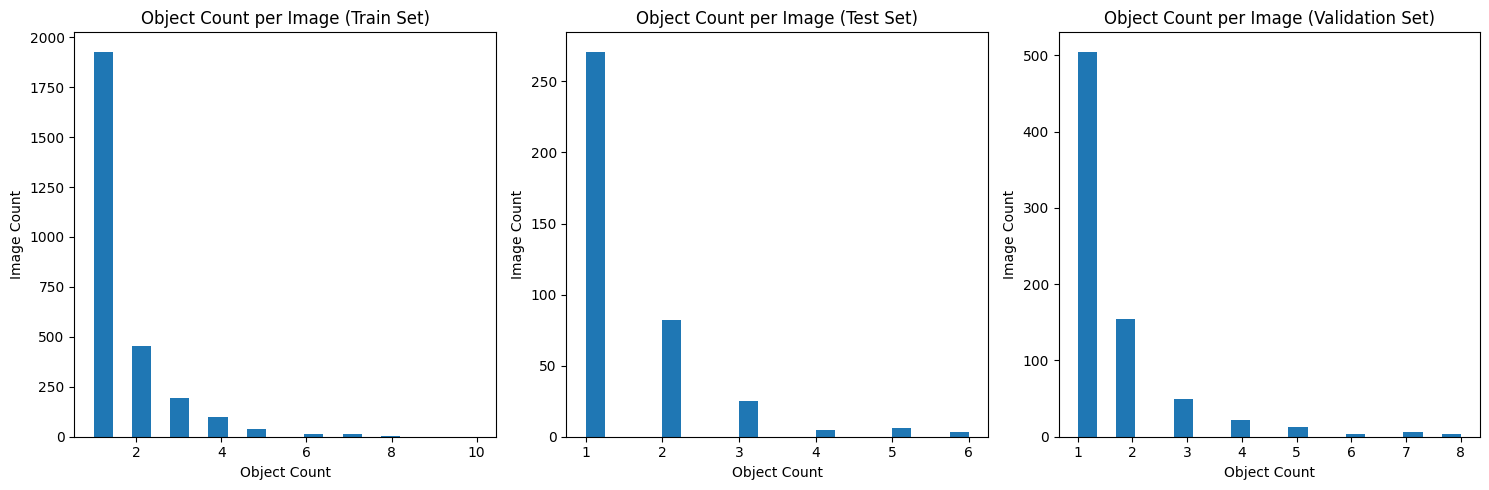

In [8]:
import matplotlib.pyplot as plt
import os

# Define the paths to the dataset folders
train_folder = '/content/yolo_datasets/violence-1/train'
test_folder = '/content/yolo_datasets/violence-1/test'
valid_folder = '/content/yolo_datasets/violence-1/valid'

# Function to get the number of objects in each image
def get_object_counts(image_folder, label_folder):
    num_objects = []
    for image_file in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, image_file.replace('.jpg', '.txt'))

        with open(label_path, 'r') as f:
            labels = f.read().splitlines()

        num_objects.append(len(labels))

    return num_objects

# Function to plot a histogram
def plot_histogram(data, title, xlabel, ylabel, ax):
    ax.hist(data, bins=20)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

# Get the number of objects per image in the train set
train_image_folder = os.path.join(train_folder, 'images')
train_label_folder = os.path.join(train_folder, 'labels')
train_object_counts = get_object_counts(train_image_folder, train_label_folder)

# Get the number of objects per image in the test set
test_image_folder = os.path.join(test_folder, 'images')
test_label_folder = os.path.join(test_folder, 'labels')
test_object_counts = get_object_counts(test_image_folder, test_label_folder)

# Get the number of objects per image in the validation set
valid_image_folder = os.path.join(valid_folder, 'images')
valid_label_folder = os.path.join(valid_folder, 'labels')
valid_object_counts = get_object_counts(valid_image_folder, valid_label_folder)

# Plot the histograms horizontally
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_histogram(train_object_counts, 'Object Count per Image (Train Set)', 'Object Count', 'Image Count', axs[0])
plot_histogram(test_object_counts, 'Object Count per Image (Test Set)', 'Object Count', 'Image Count', axs[1])
plot_histogram(valid_object_counts, 'Object Count per Image (Validation Set)', 'Object Count', 'Image Count', axs[2])

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

### B. Class Distribution Analysis

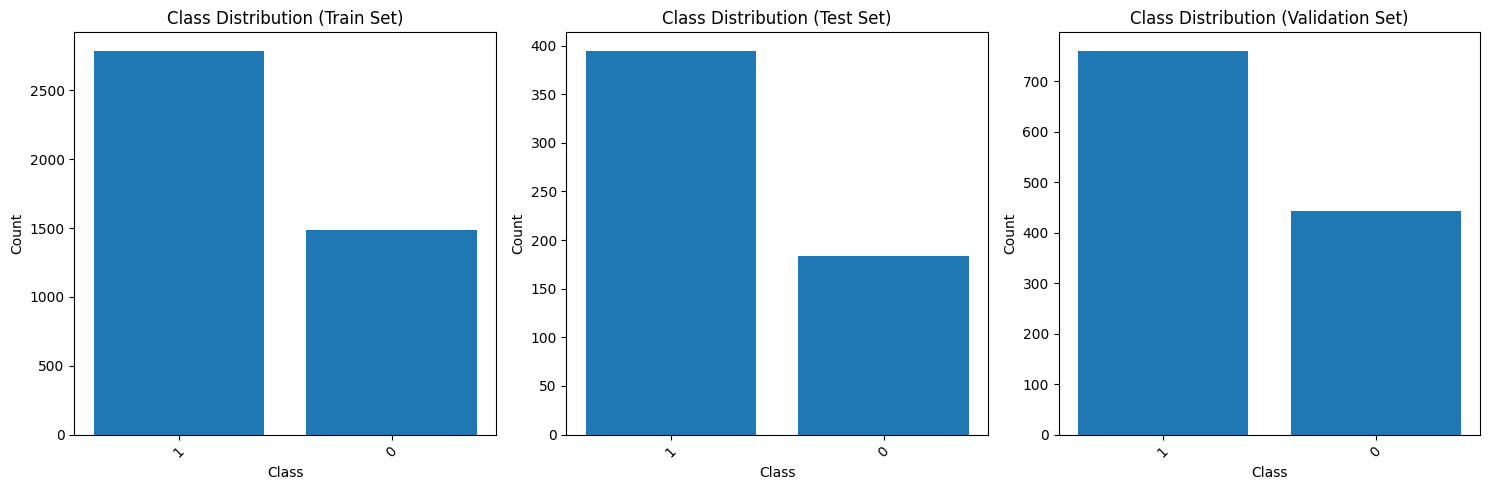

In [9]:
# Function to get the class distribution
def get_class_distribution(label_folder):
    class_counts = {}
    for label_file in os.listdir(label_folder):
        label_path = os.path.join(label_folder, label_file)

        with open(label_path, 'r') as f:
            labels = f.read().splitlines()

        for label in labels:
            class_name = label.split()[0]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    return class_counts

# Get the class distribution in the train set
train_label_folder = os.path.join(train_folder, 'labels')
train_class_distribution = get_class_distribution(train_label_folder)

# Get the class distribution in the test set
test_label_folder = os.path.join(test_folder, 'labels')
test_class_distribution = get_class_distribution(test_label_folder)

# Get the class distribution in the validation set
valid_label_folder = os.path.join(valid_folder, 'labels')
valid_class_distribution = get_class_distribution(valid_label_folder)

# Plot the class distributions
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

class_names_train = train_class_distribution.keys()
class_counts_train = train_class_distribution.values()
axs[0].bar(class_names_train, class_counts_train)
axs[0].set_title('Class Distribution (Train Set)')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')
axs[0].tick_params(axis='x', rotation=45)

class_names_test = test_class_distribution.keys()
class_counts_test = test_class_distribution.values()
axs[1].bar(class_names_test, class_counts_test)
axs[1].set_title('Class Distribution (Test Set)')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')
axs[1].tick_params(axis='x', rotation=45)

class_names_valid = valid_class_distribution.keys()
class_counts_valid = valid_class_distribution.values()
axs[2].bar(class_names_valid, class_counts_valid)
axs[2].set_title('Class Distribution (Validation Set)')
axs[2].set_xlabel('Class')
axs[2].set_ylabel('Count')
axs[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### C. Object Size Distribution Analysis

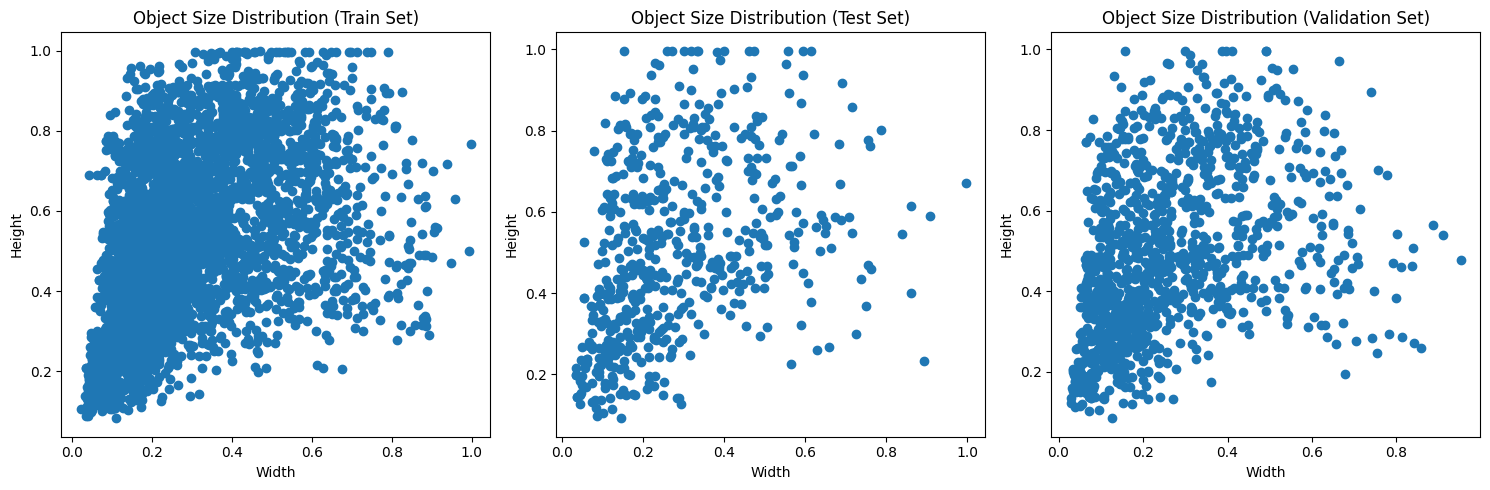

In [10]:
# Function to get object sizes (width and height)
def get_object_sizes(image_folder, label_folder):
    object_sizes = []
    for image_file in os.listdir(image_folder):
        image_path = os.path.join(image_folder, image_file)
        label_path = os.path.join(label_folder, image_file.replace('.jpg', '.txt'))

        with open(label_path, 'r') as f:
            labels = f.read().splitlines()

        for label in labels:
            _, _, width, height = map(float, label.split()[1:])
            object_sizes.append((width, height))

    return object_sizes

# Get the object sizes in the train set
train_object_sizes = get_object_sizes(train_image_folder, train_label_folder)
train_widths, train_heights = zip(*train_object_sizes)

# Get the object sizes in the test set
test_object_sizes = get_object_sizes(test_image_folder, test_label_folder)
test_widths, test_heights = zip(*test_object_sizes)

# Get the object sizes in the validation set
valid_object_sizes = get_object_sizes(valid_image_folder, valid_label_folder)
valid_widths, valid_heights = zip(*valid_object_sizes)

# Plot the object size distributions
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Train set
axs[0].scatter(train_widths, train_heights)
axs[0].set_title('Object Size Distribution (Train Set)')
axs[0].set_xlabel('Width')
axs[0].set_ylabel('Height')

# Test set
axs[1].scatter(test_widths, test_heights)
axs[1].set_title('Object Size Distribution (Test Set)')
axs[1].set_xlabel('Width')
axs[1].set_ylabel('Height')

# Validation set
axs[2].scatter(valid_widths, valid_heights)
axs[2].set_title('Object Size Distribution (Validation Set)')
axs[2].set_xlabel('Width')
axs[2].set_ylabel('Height')

plt.tight_layout()
plt.show()

## 4. Data Modeling

#### Model Training :

In [11]:
%cd {HOME}

/content


In [12]:
# Load a model
model = YOLO('yolov8s.yaml').load('yolov8s.pt')


                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256

In [14]:
# Train the model
data= '/content/yolo_datasets/violence-1/data.yaml '
results = model.train(data=data, epochs=150, imgsz=640)

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/yolo_datasets/violence-1/data.yaml , epochs=150, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscrip

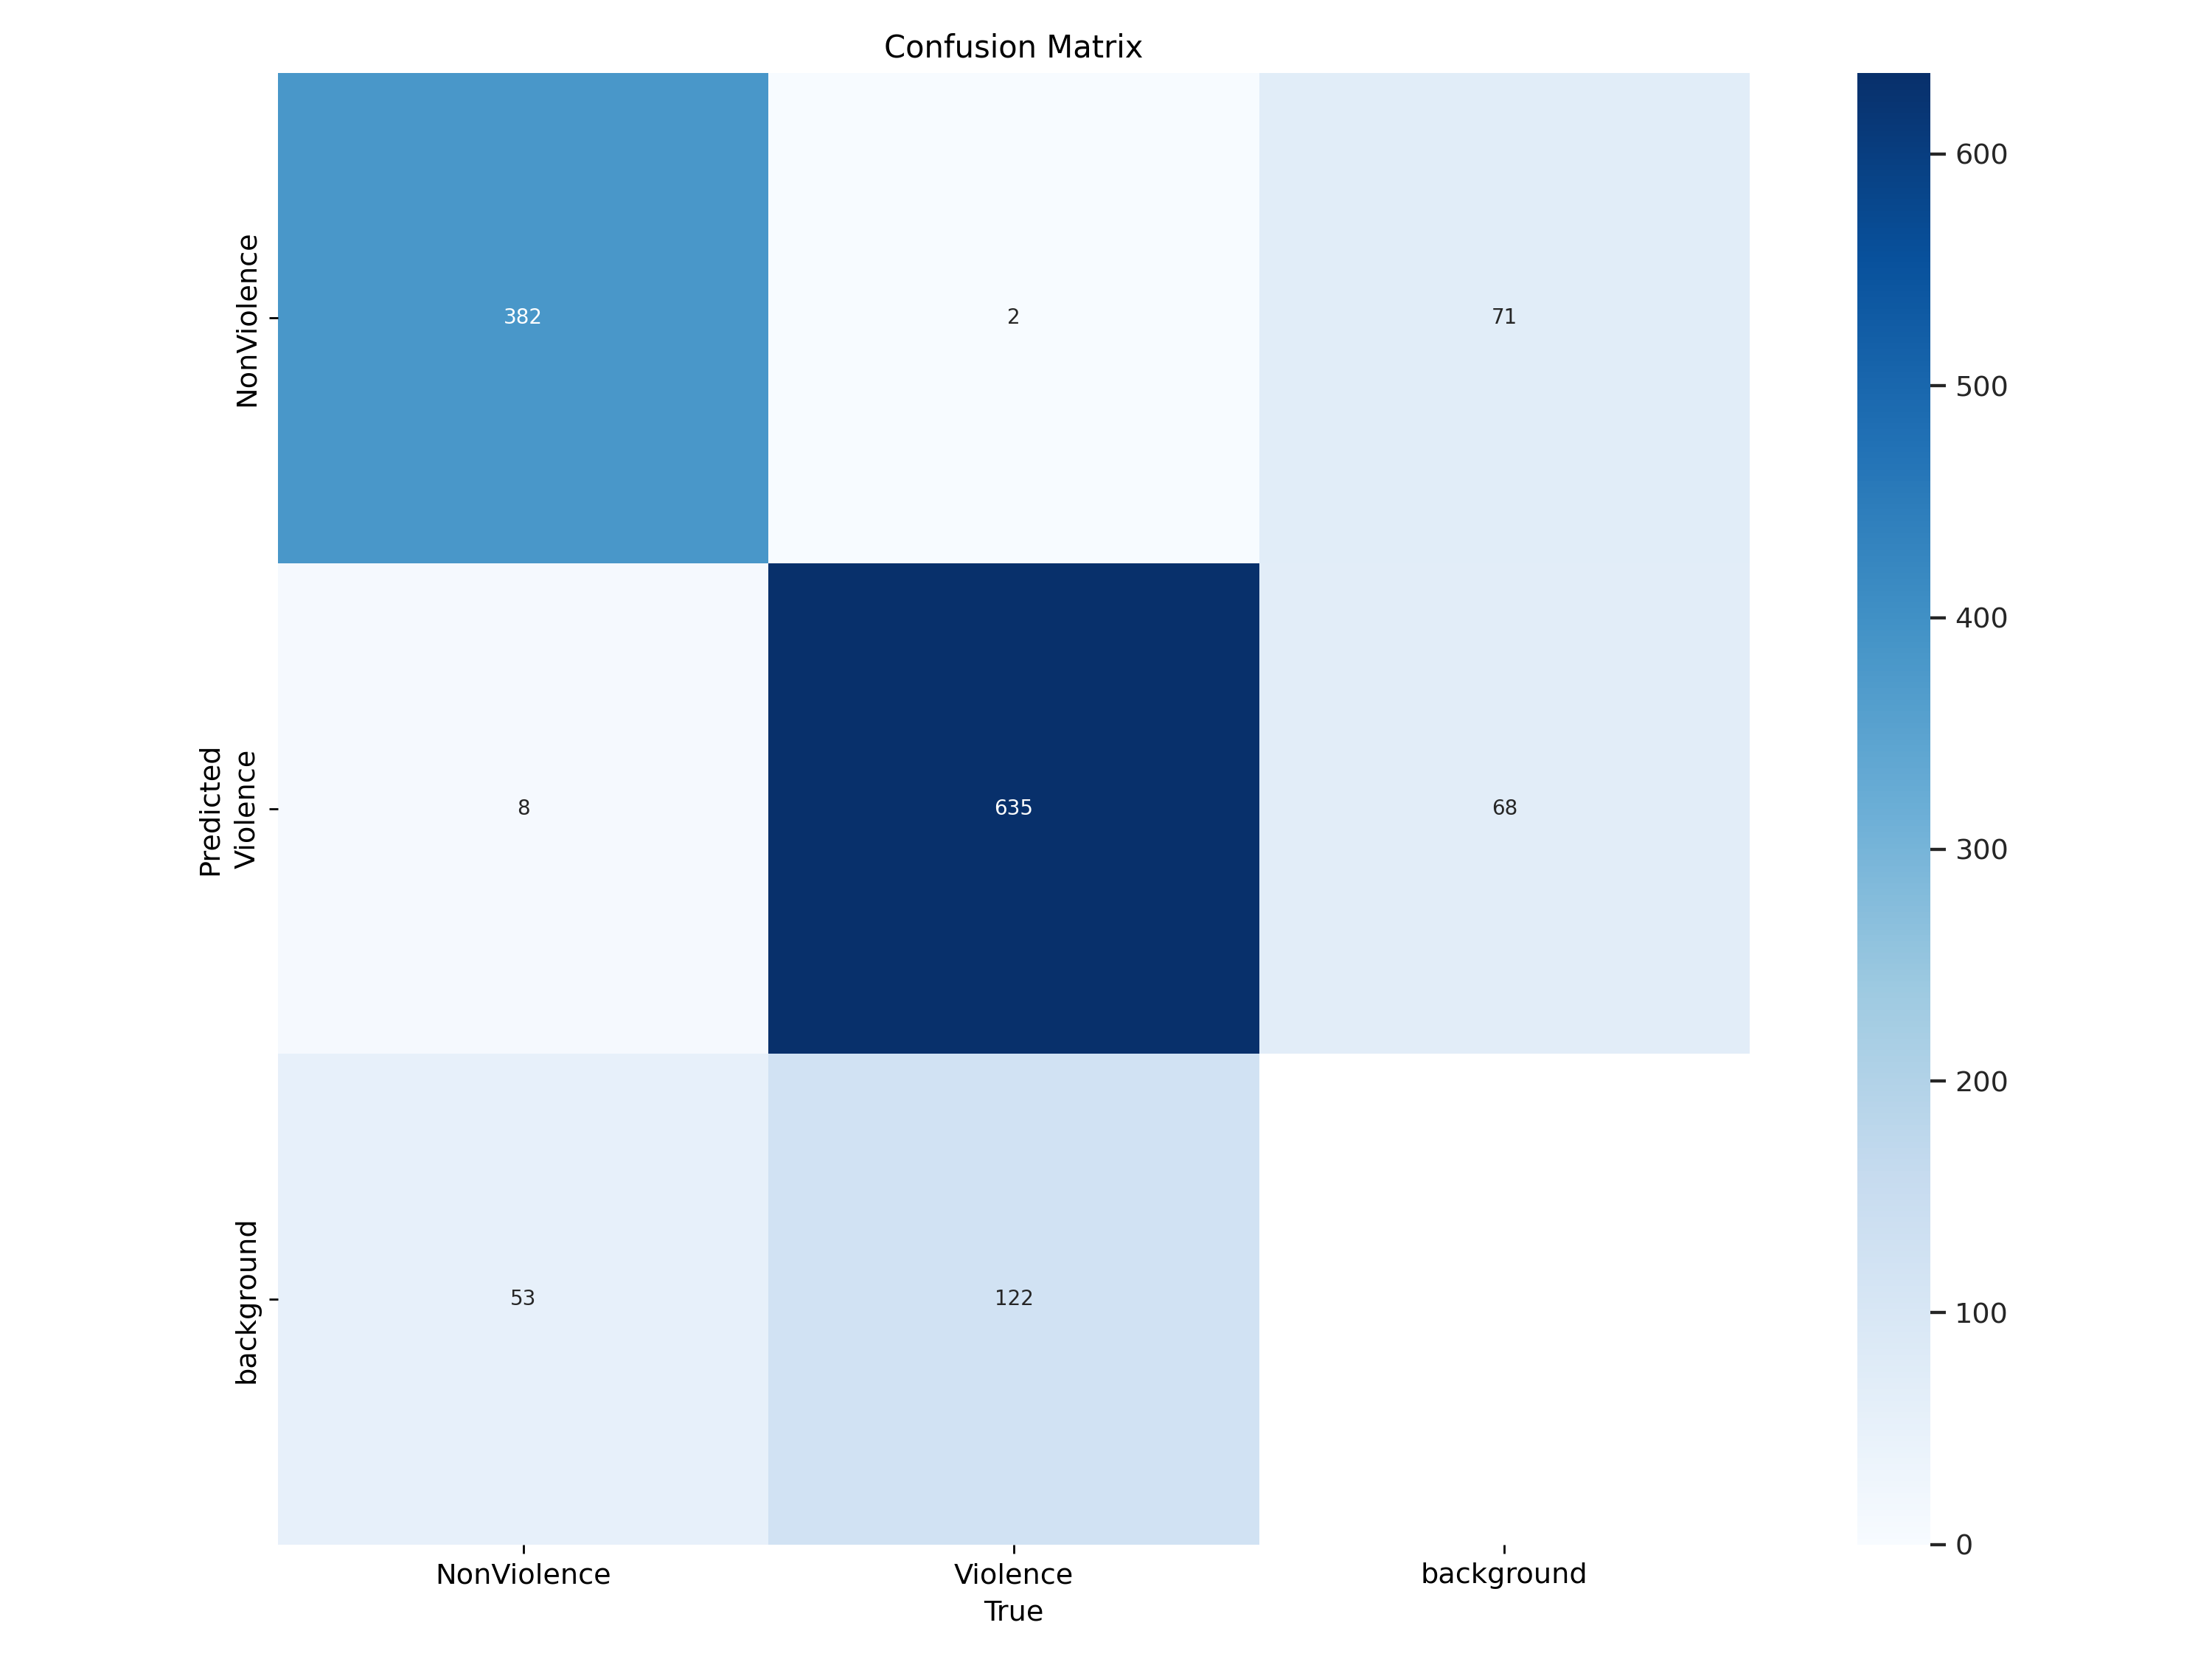

In [17]:
Image(filename=f'{HOME}/runs/detect/train1/confusion_matrix.png', width=600)

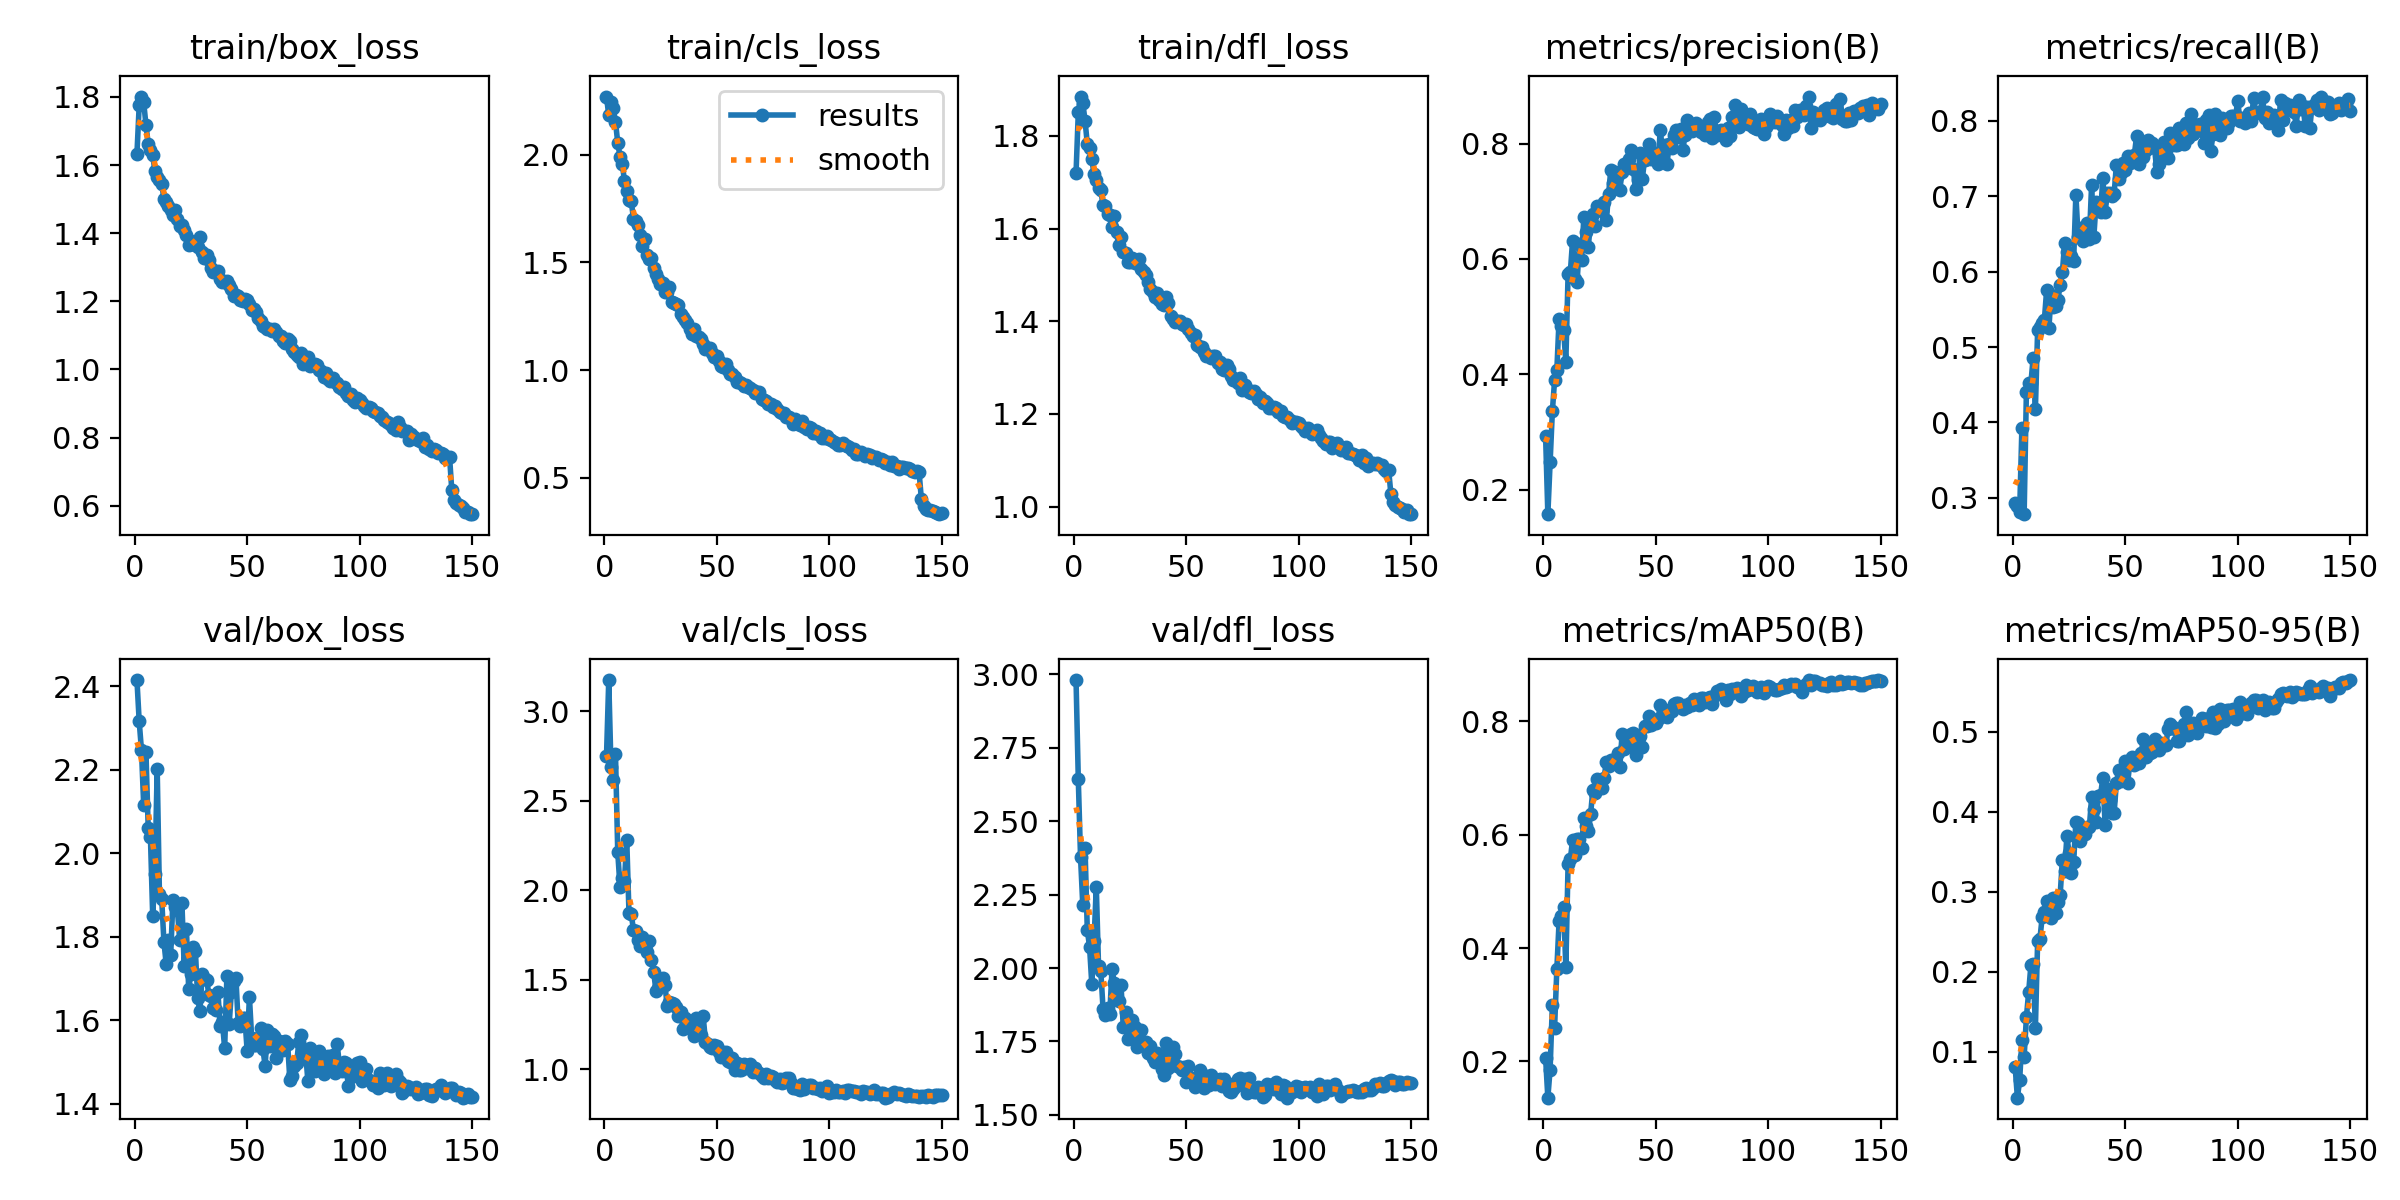

In [18]:
Image(filename=f'{HOME}/runs/detect/train/results.png', width=1500)

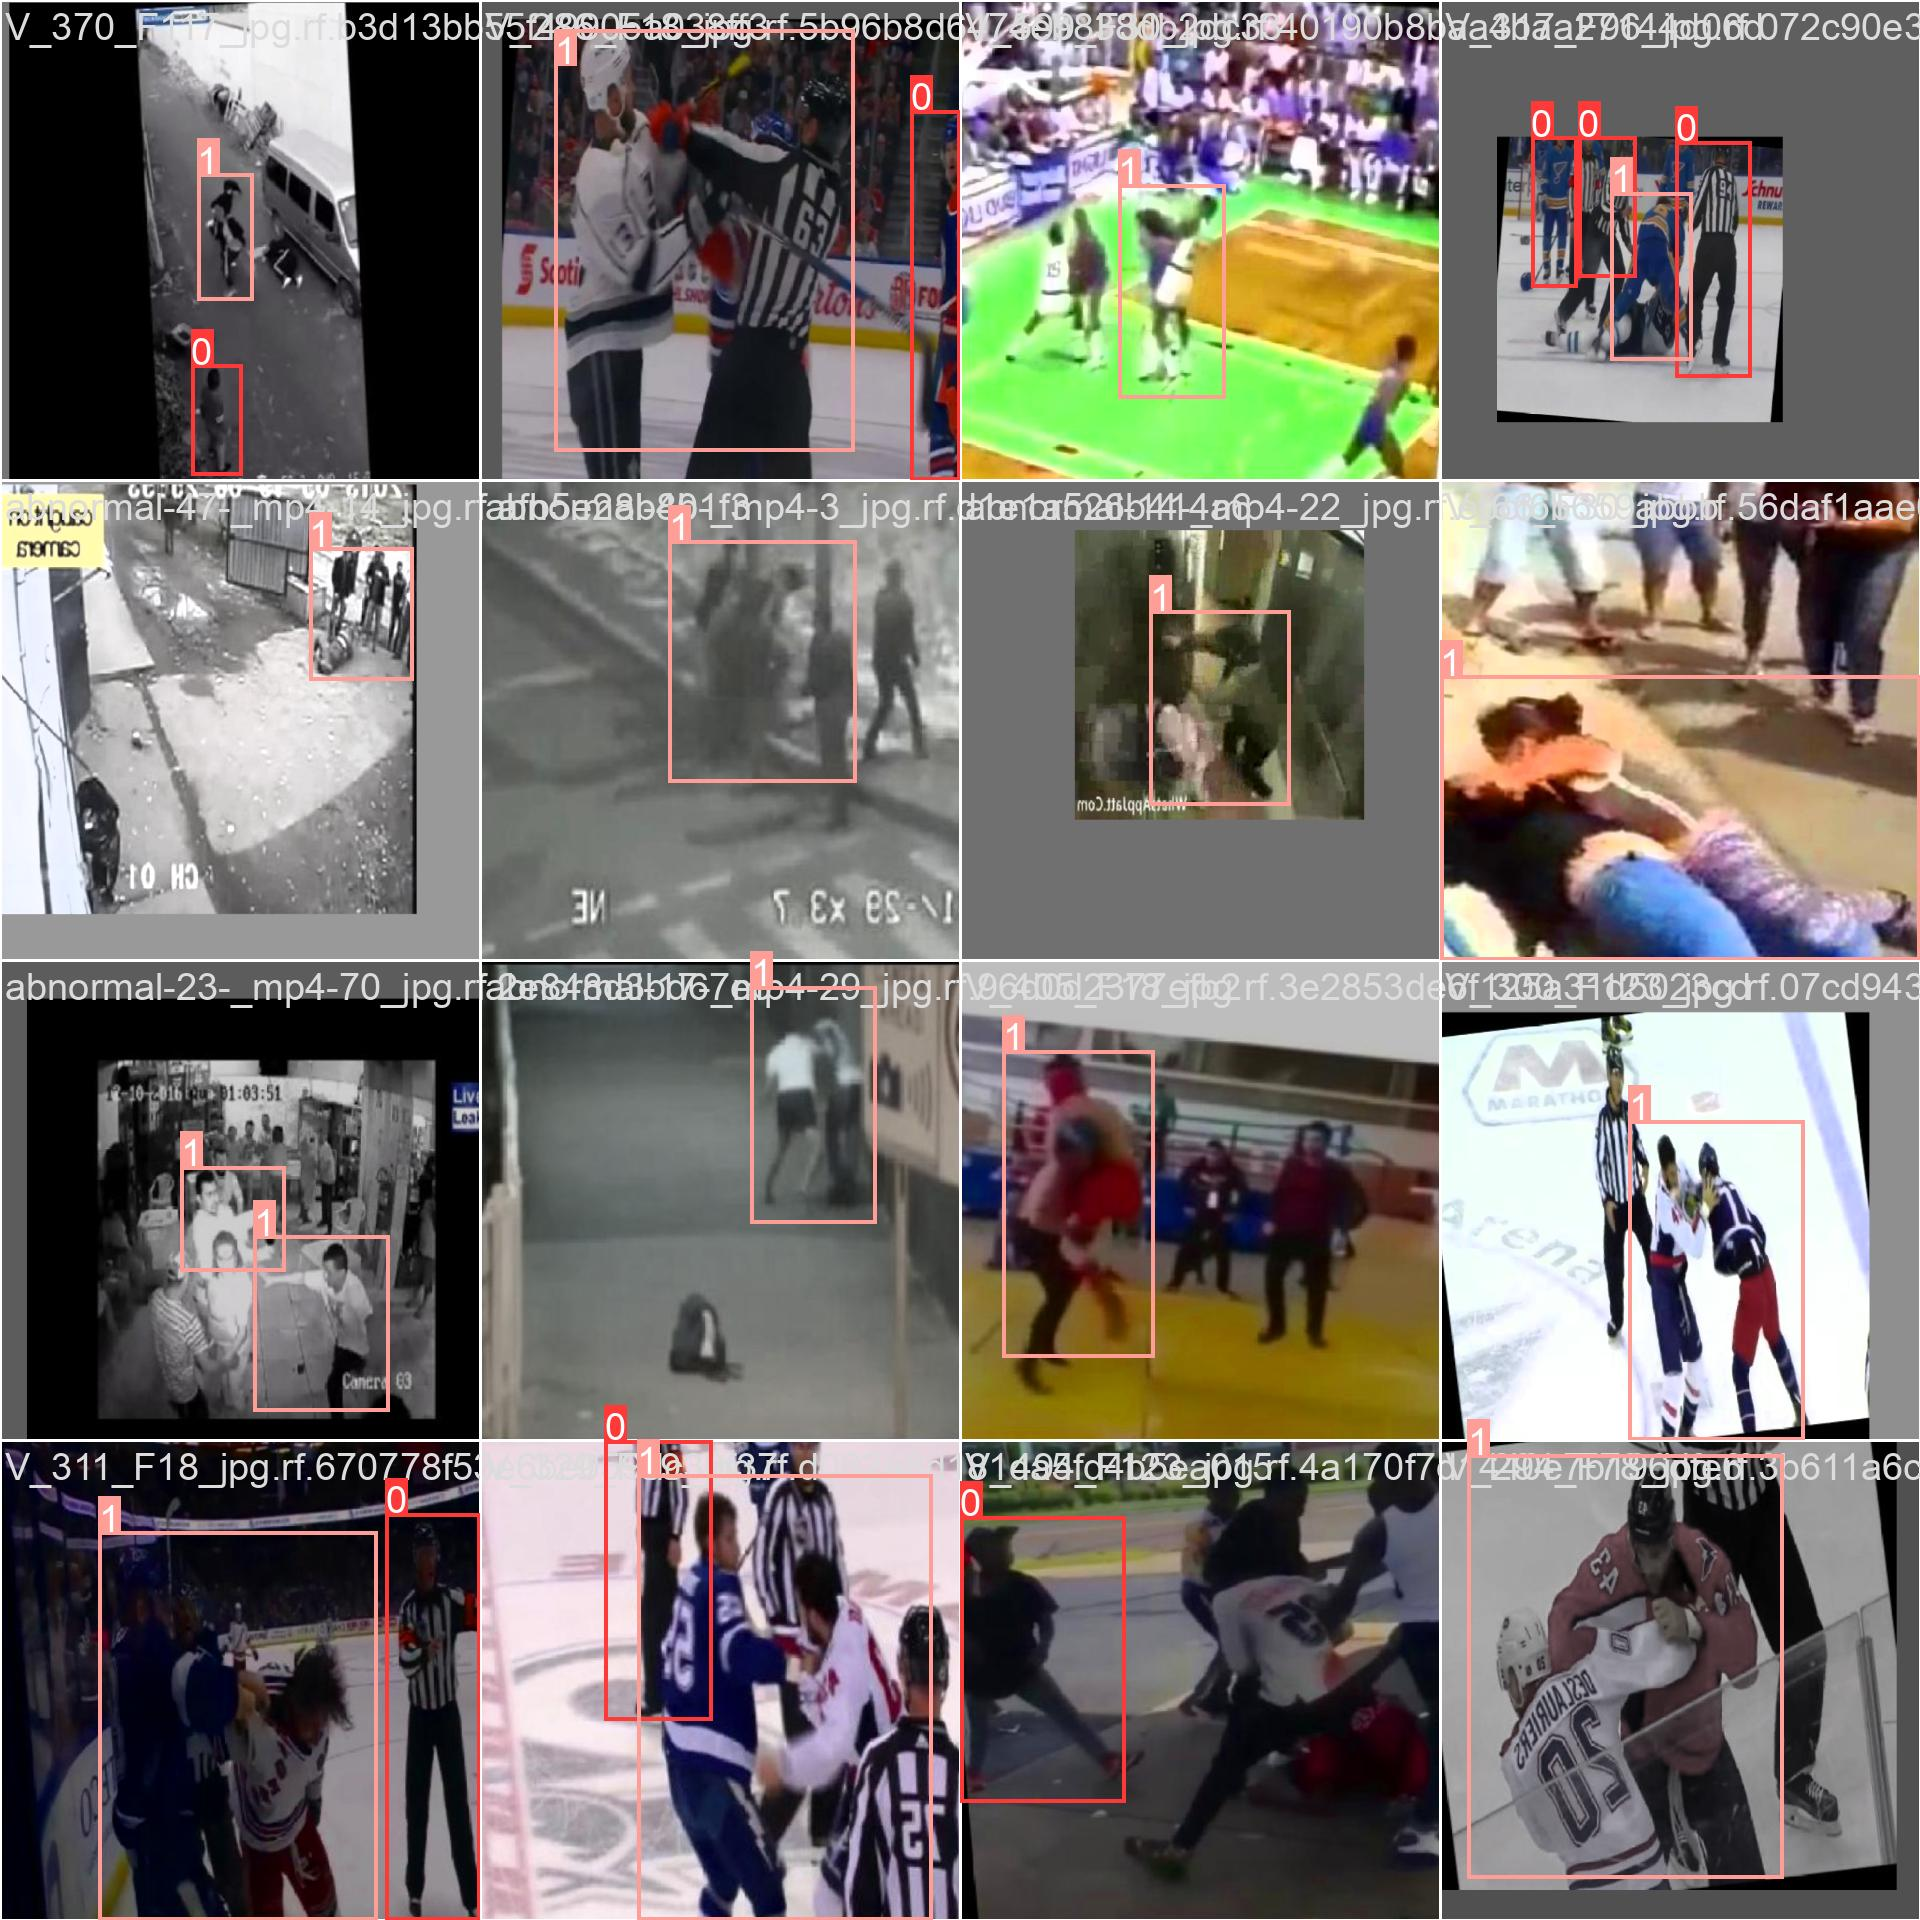

In [21]:
Image(filename=f'{HOME}/runs/detect/train/train_batch24220.jpg', width=600)

#### Model Evaluation on test set

In [25]:
testing = model.val(data='/content/yolo_datasets/violence-1/data.yaml',split='test')

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
val: Scanning /content/yolo_datasets/violence-1/test/labels... 392 images, 0 backgrounds, 0 corrupt: 100%|██████████| 392/392 [00:00<00:00, 705.11it/s]
val: New cache created: /content/yolo_datasets/violence-1/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:09<00:00,  2.61it/s]
                   all        392        578      0.914      0.809      0.889      0.589
           NonViolence        392        184      0.911      0.848      0.899      0.621
              Violence        392        394      0.916      0.771      0.879      0.556
Speed: 1.4ms preprocess, 10.5ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/val2


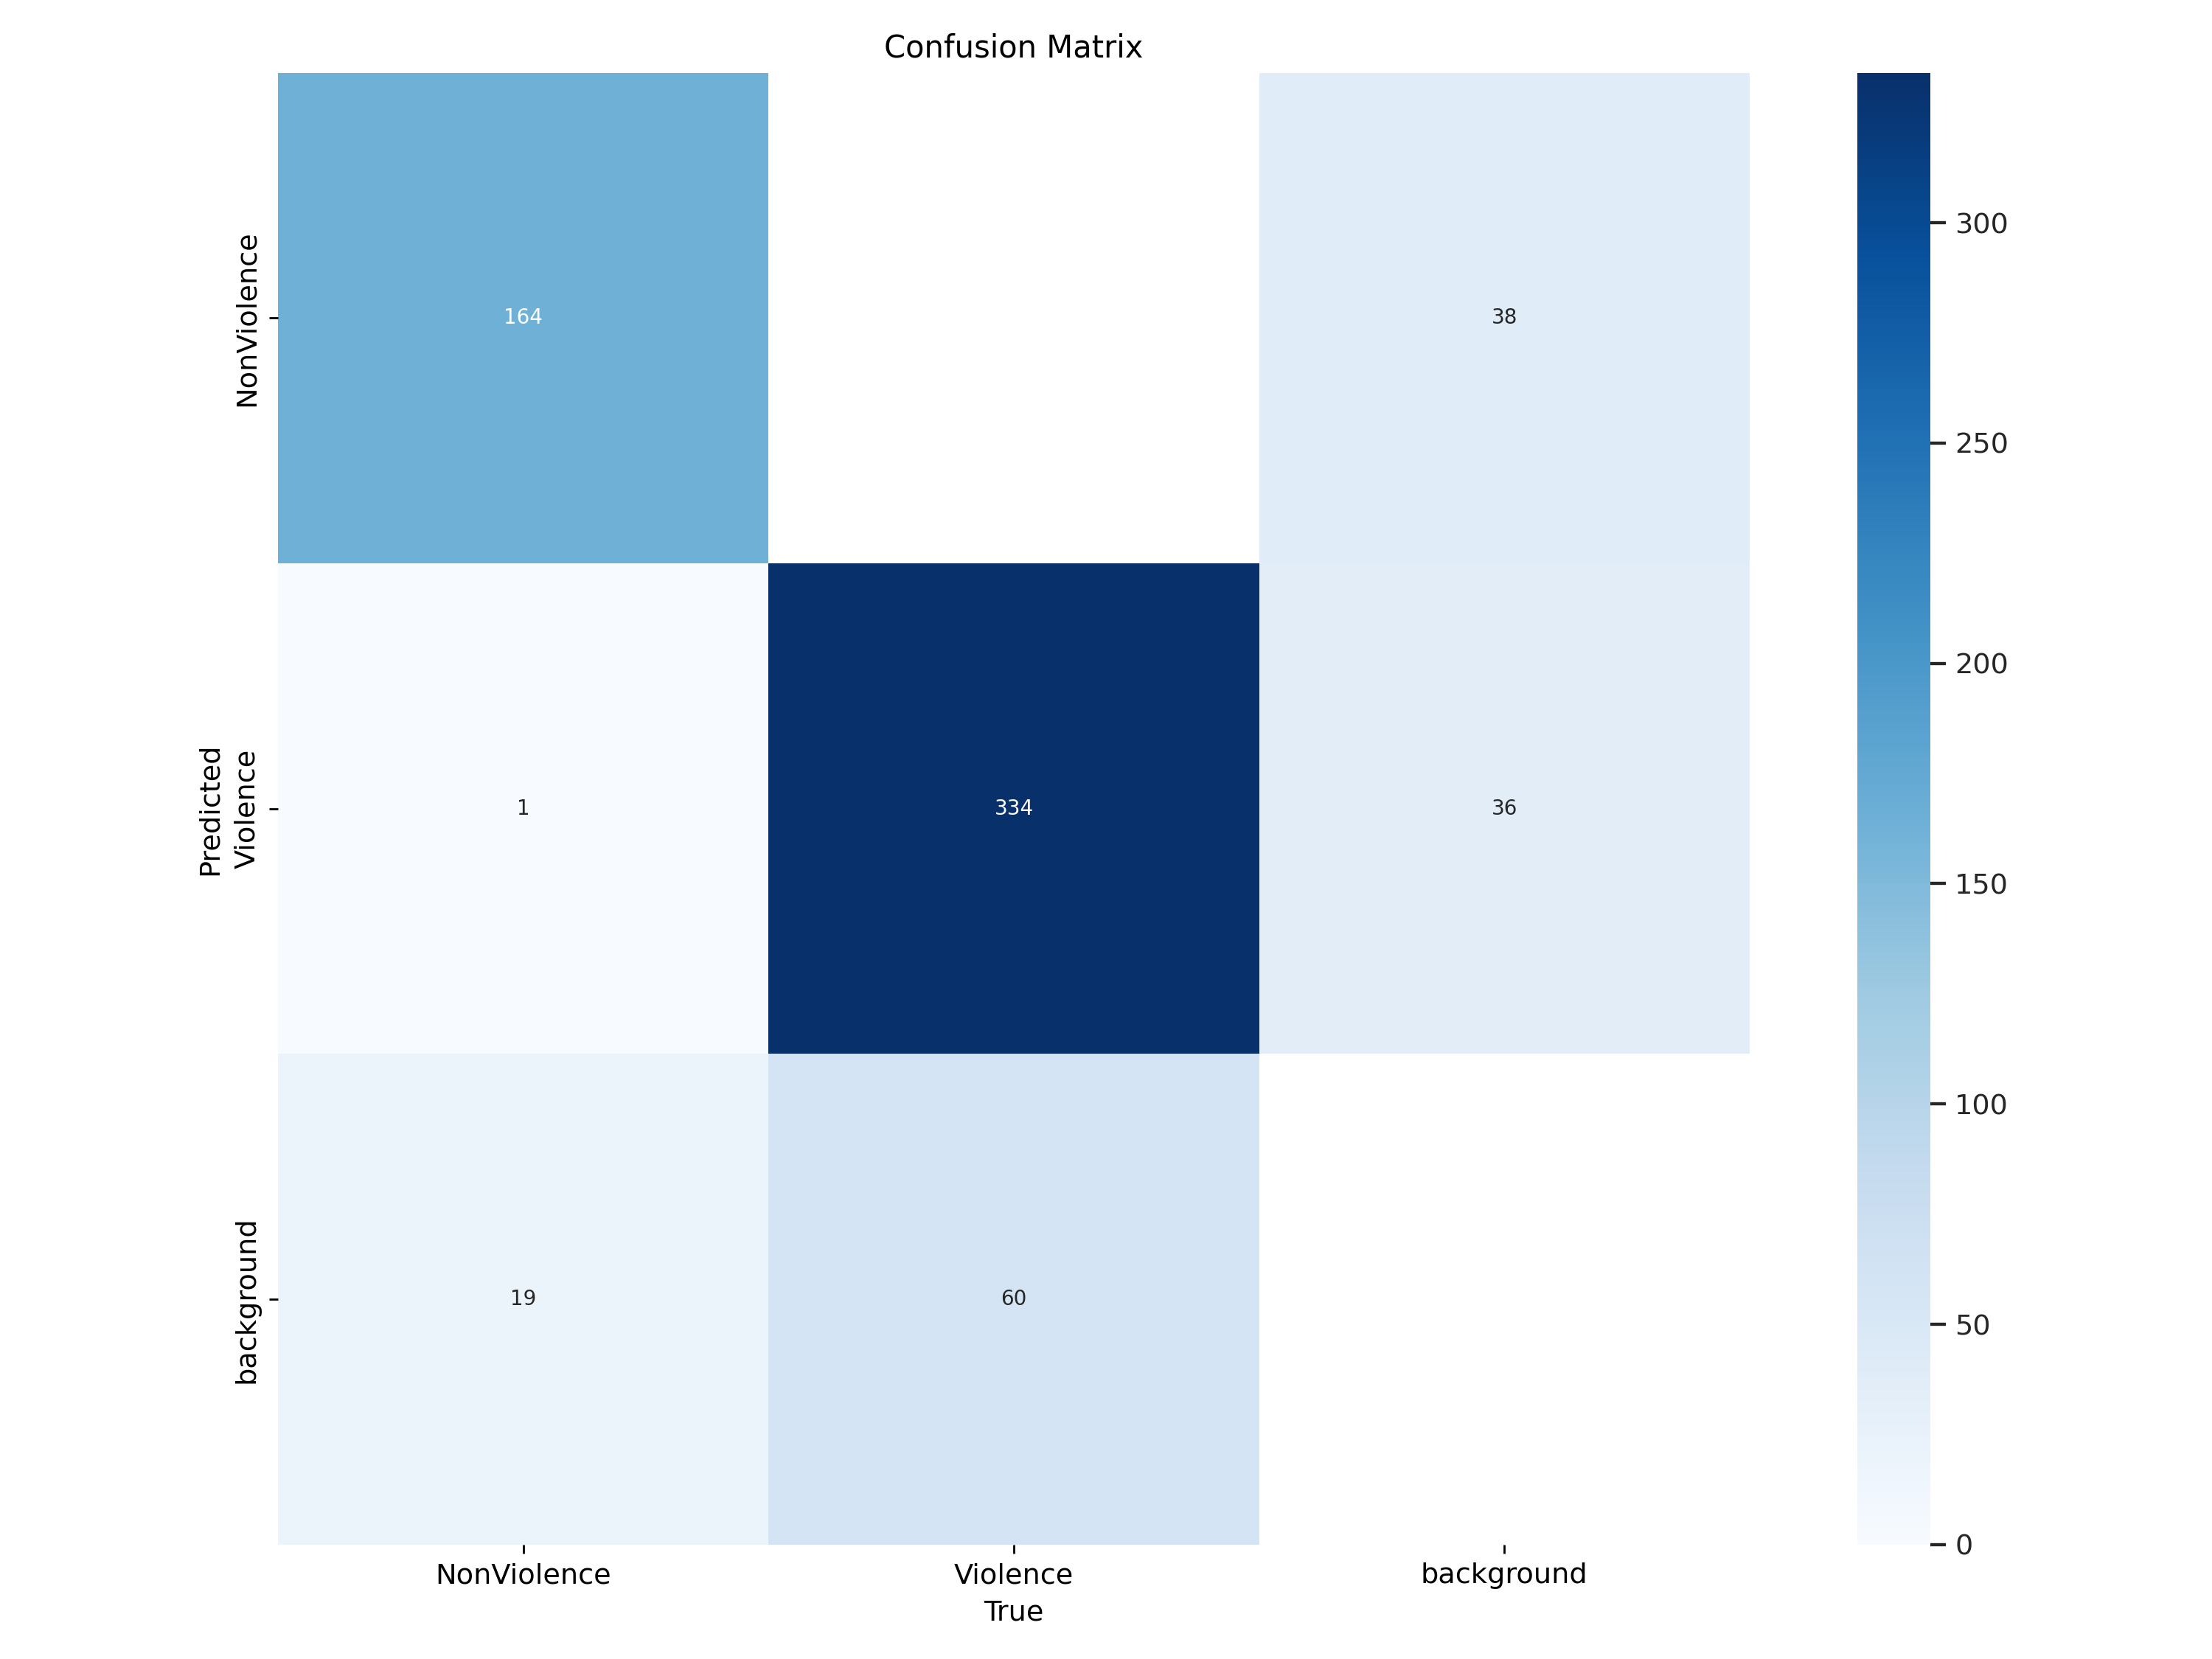

In [27]:
Image(filename=f'{HOME}/runs/detect/val2/confusion_matrix.png', width=600)

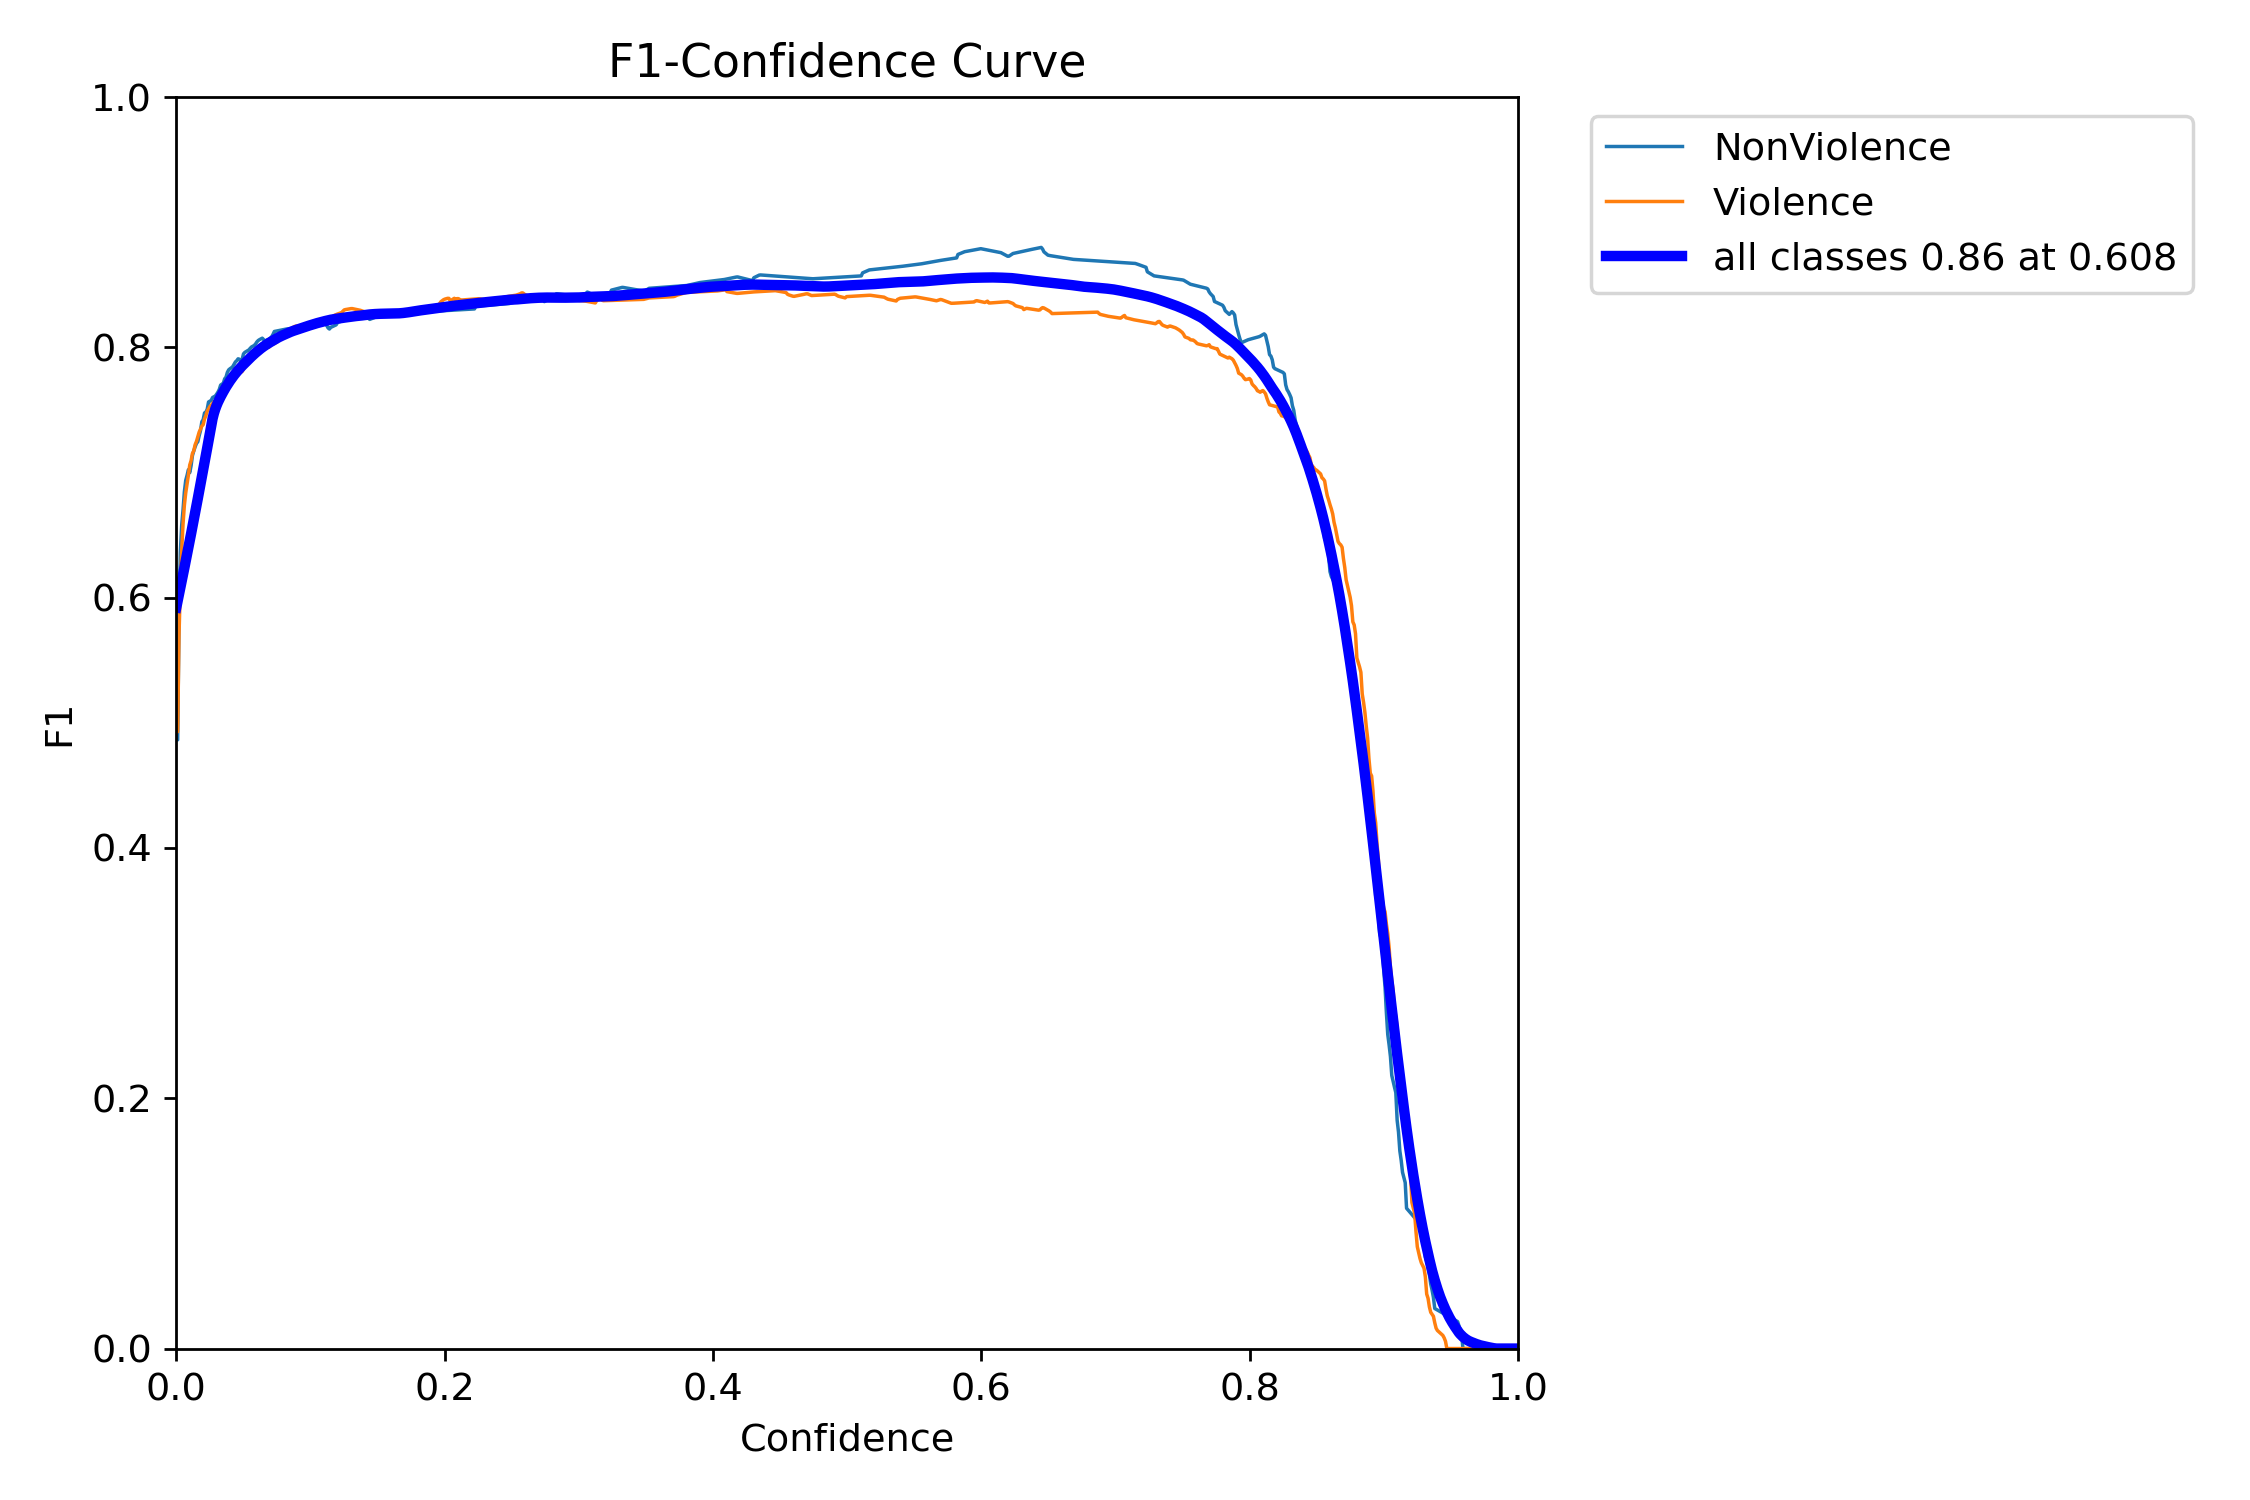

In [28]:
Image(filename=f'{HOME}/runs/detect/val2/F1_curve.png', width=600)

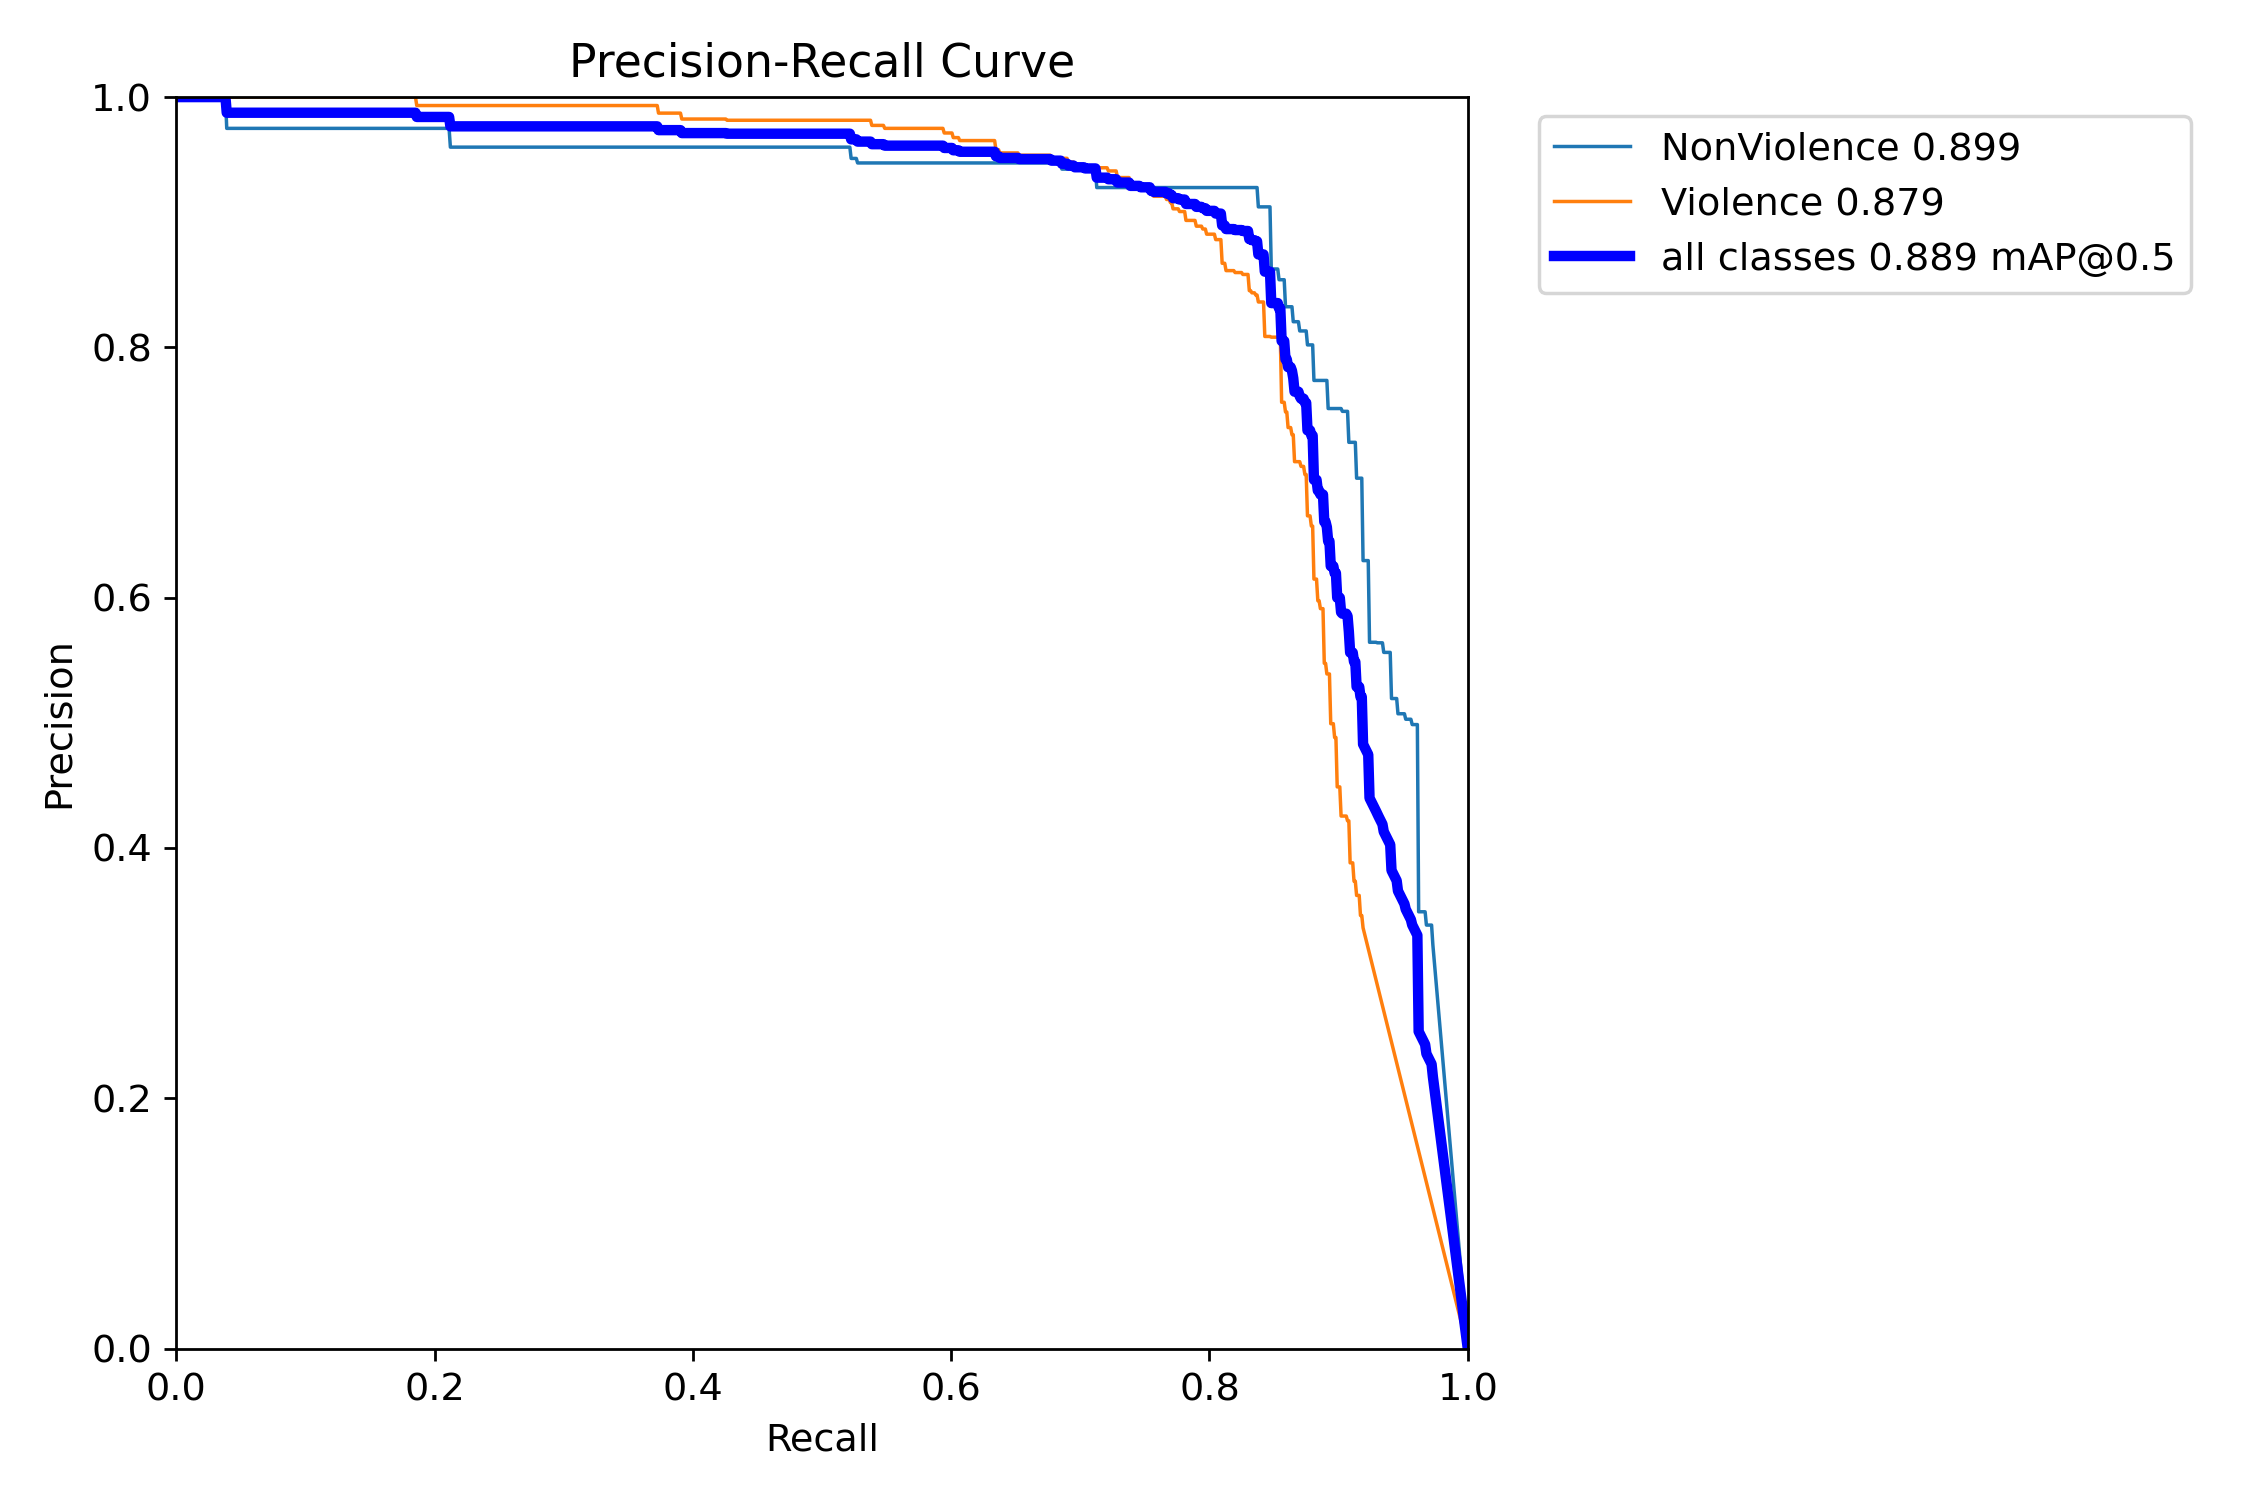

In [29]:
Image(filename=f'{HOME}/runs/detect/val2/PR_curve.png', width=600)

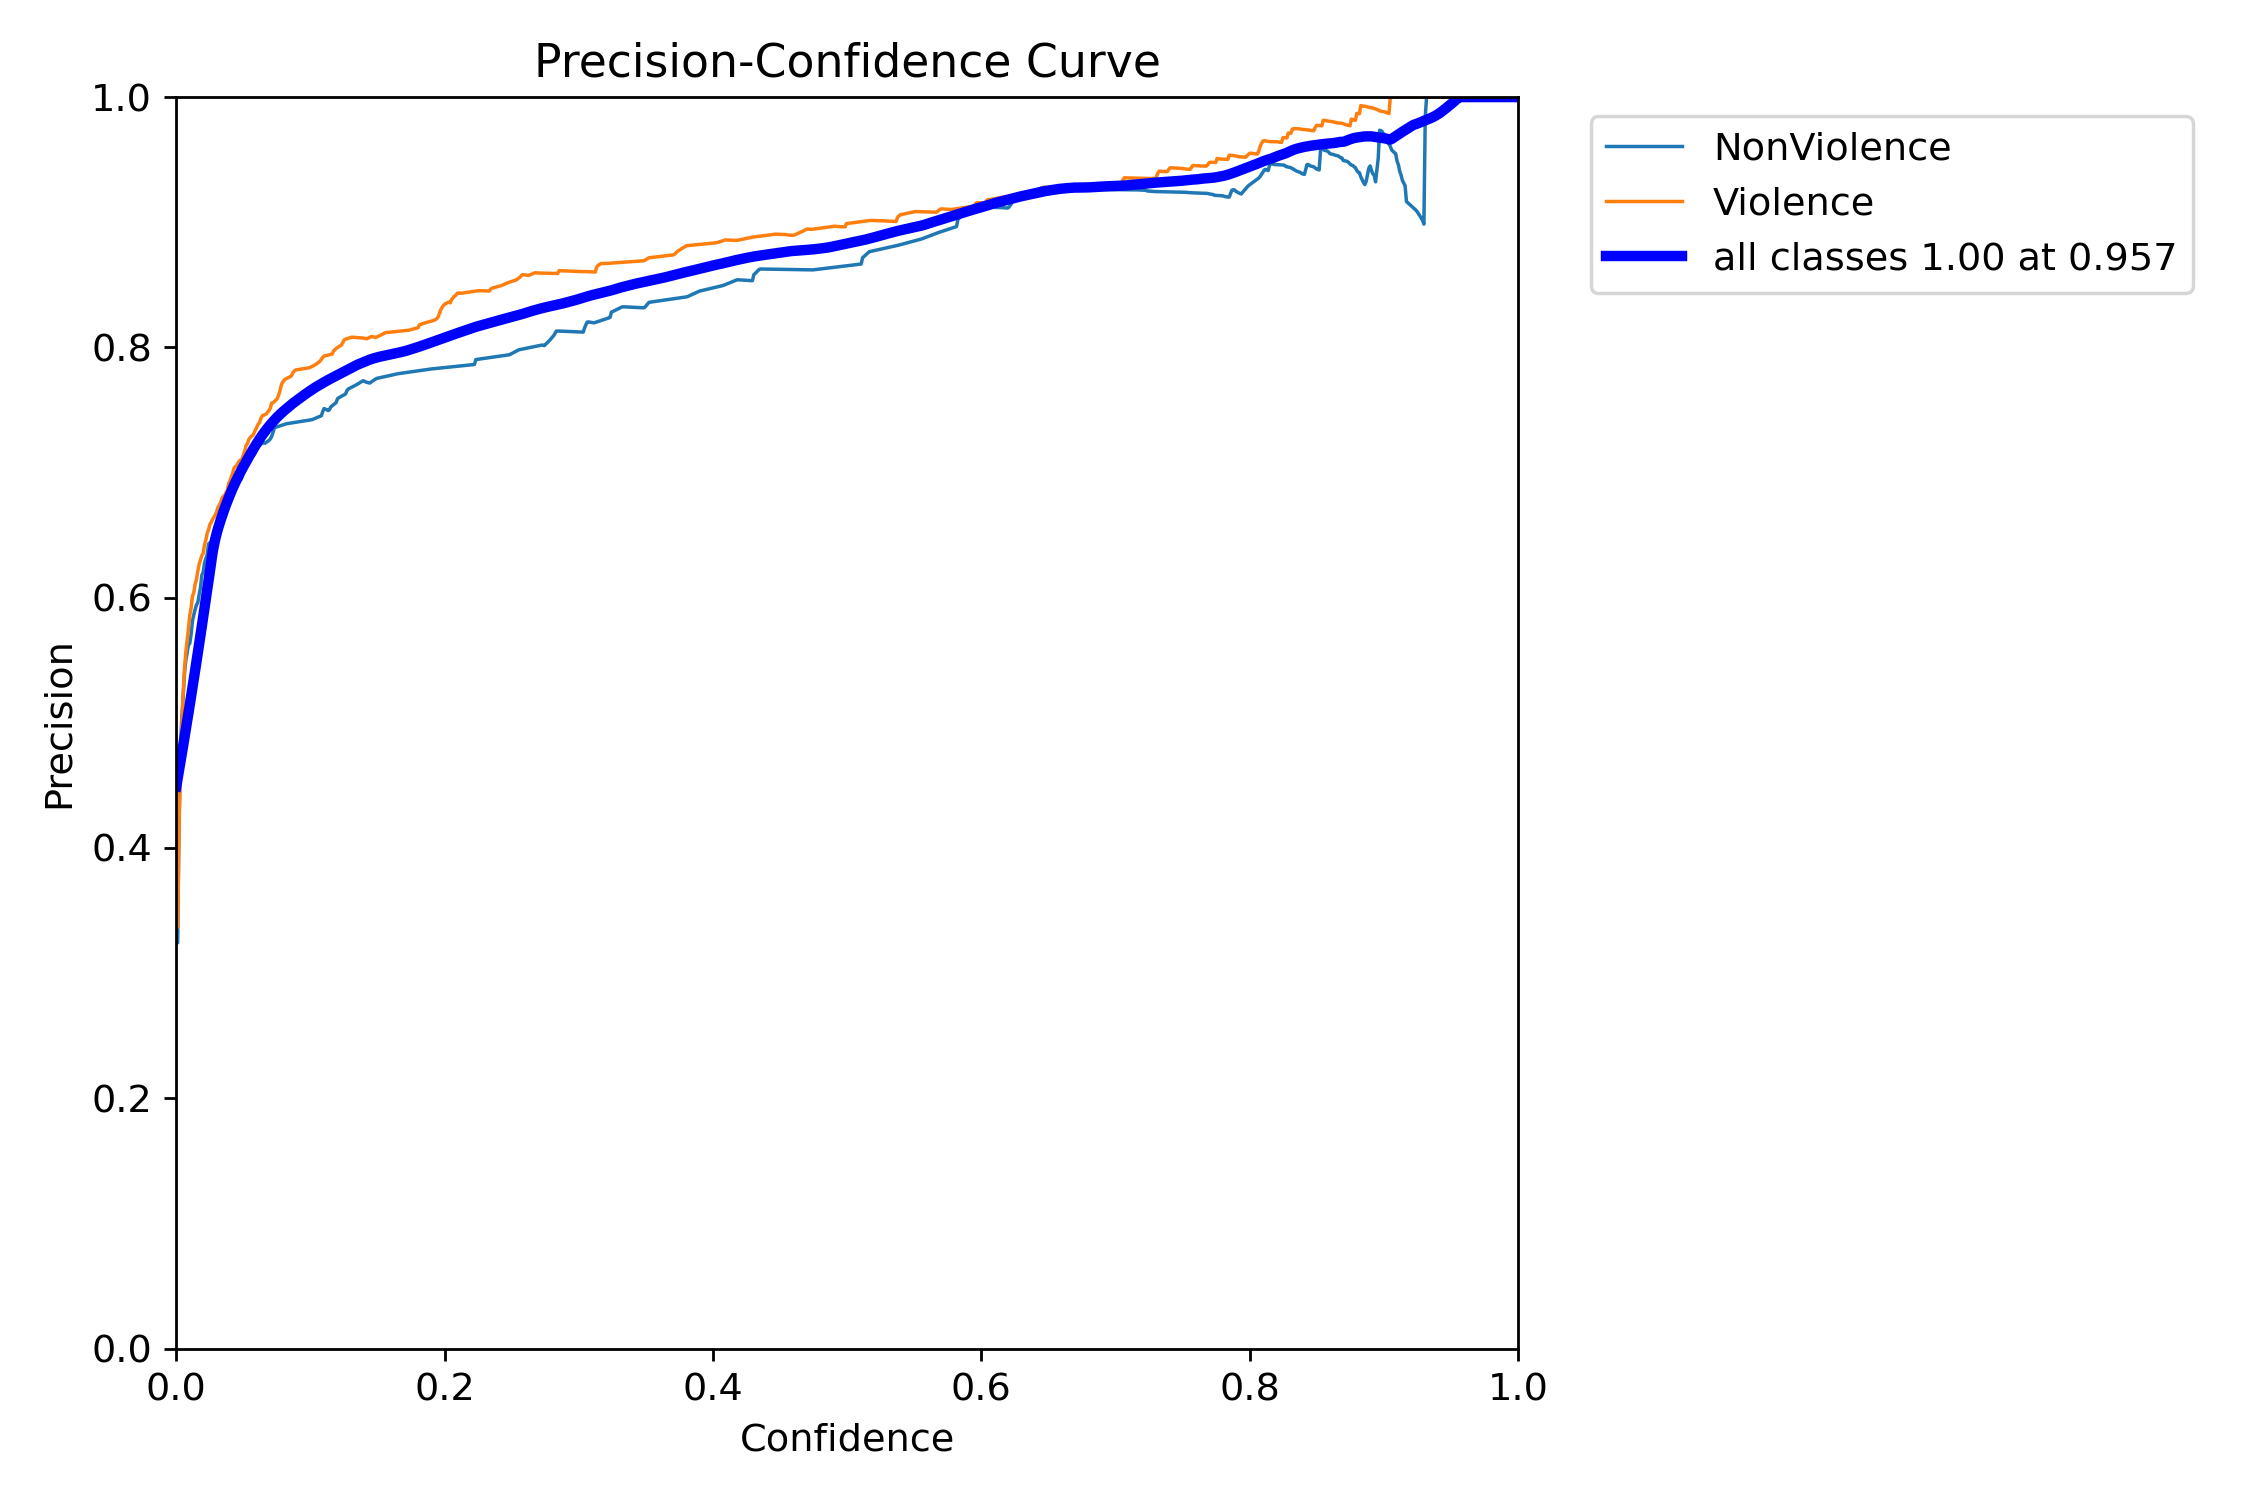

In [30]:
Image(filename=f'{HOME}/runs/detect/val2/P_curve.png', width=600)

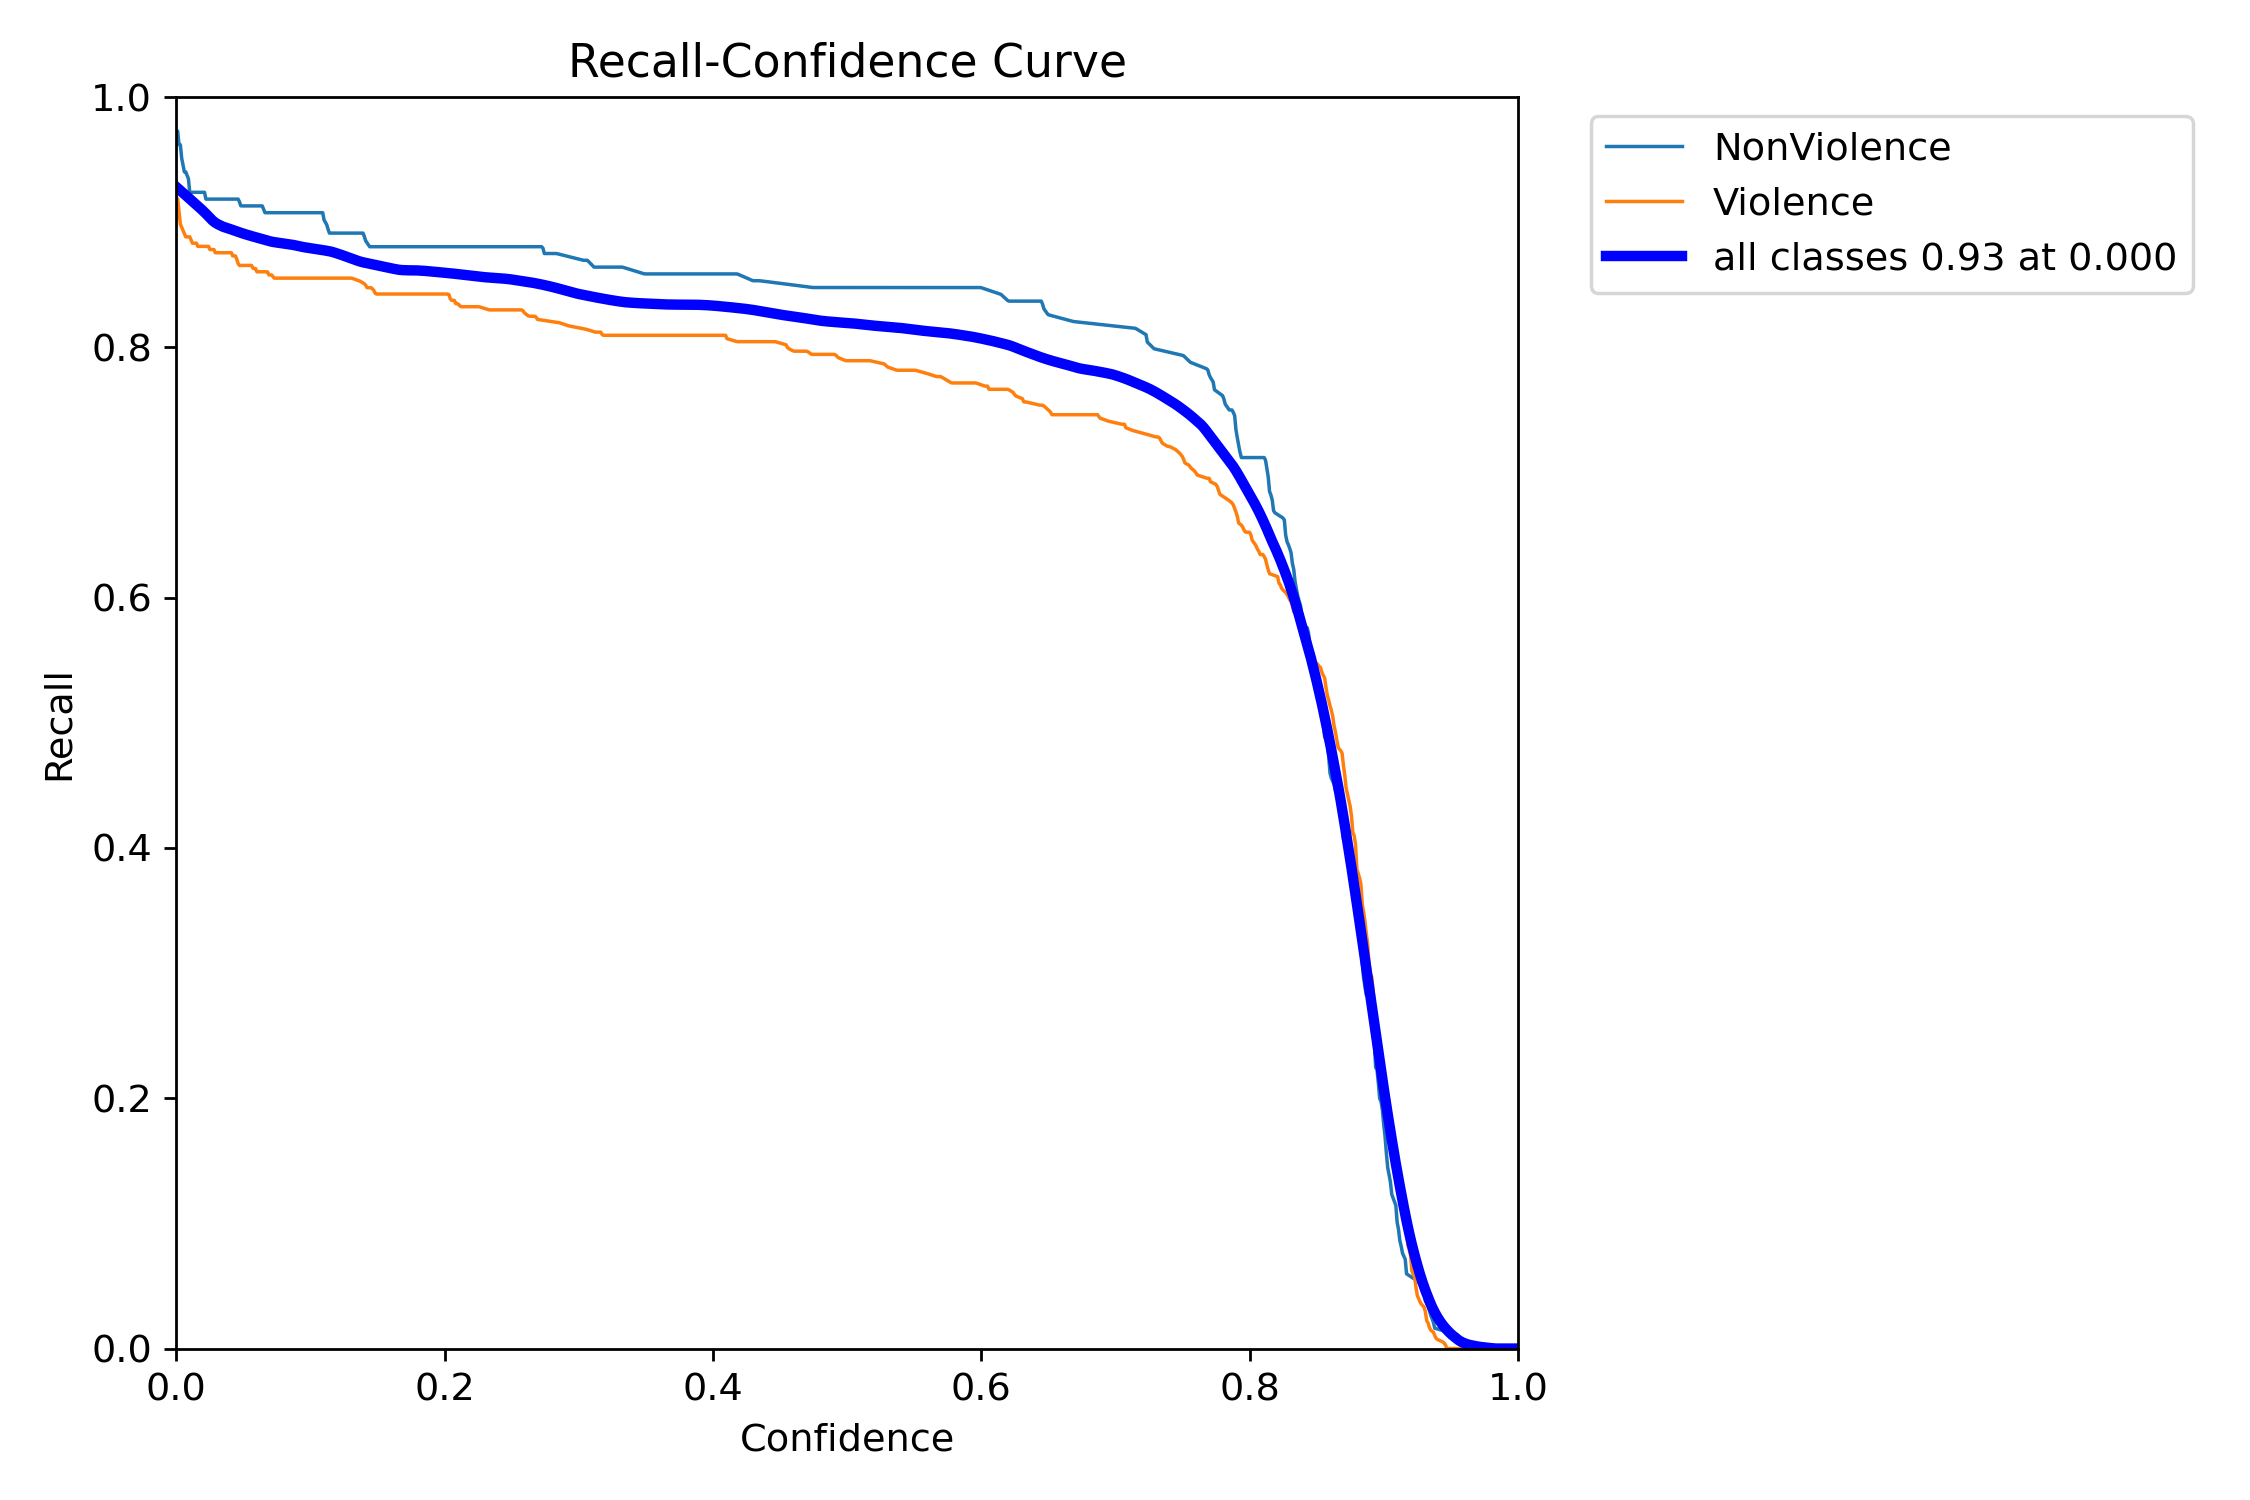

In [31]:
Image(filename=f'{HOME}/runs/detect/val2/R_curve.png', width=600)

In [32]:
model.predict('/content/yolo_datasets/violence-1/test/images', save=True, imgsz=640, conf=0.5)


image 1/392 /content/yolo_datasets/violence-1/test/images/NV_118_F28_jpg.rf.2c471784ea3ab41efe79f4082cd4618a.jpg: 640x640 2 NonViolences, 1 Violence, 16.3ms
image 2/392 /content/yolo_datasets/violence-1/test/images/NV_118_F40_jpg.rf.b9089ab60a18ef66039f4e246521dc1a.jpg: 640x640 1 NonViolence, 16.4ms
image 3/392 /content/yolo_datasets/violence-1/test/images/NV_118_F60_jpg.rf.5dc3a58b4bb6ca5b5622997ad097772b.jpg: 640x640 1 NonViolence, 16.3ms
image 4/392 /content/yolo_datasets/violence-1/test/images/NV_118_F80_jpg.rf.4f603de1035f046cb8a8451e1b06068d.jpg: 640x640 1 NonViolence, 16.2ms
image 5/392 /content/yolo_datasets/violence-1/test/images/NV_137_F44_jpg.rf.19f4e81878093521f1af2f105414a1db.jpg: 640x640 1 NonViolence, 16.2ms
image 6/392 /content/yolo_datasets/violence-1/test/images/NV_226_F156_jpg.rf.52c963a1c7549aa8340e65b9f4127905.jpg: 640x640 2 NonViolences, 16.2ms
image 7/392 /content/yolo_datasets/violence-1/test/images/NV_247_F12_jpg.rf.9b2d0ff5f21ce0a589f2cdc1f0a4064e.jpg: 640x64

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'NonViolence', 1: 'Violence'}
 orig_img: array([[[243, 248, 239],
         [243, 248, 239],
         [243, 248, 239],
         ...,
         [ 68,  83,  69],
         [ 68,  83,  69],
         [ 70,  85,  71]],
 
        [[243, 248, 239],
         [243, 248, 239],
         [243, 248, 239],
         ...,
         [ 68,  83,  69],
         [ 69,  84,  70],
         [ 72,  87,  73]],
 
        [[243, 248, 239],
         [243, 248, 239],
         [243, 248, 239],
         ...,
         [ 75,  90,  76],
         [ 79,  94,  80],
         [ 82,  97,  83]],
 
        ...,
 
        [[ 13,  22,  85],
         [ 13,  22,  85],
         [ 13,  22,  85],
         ...,
         [ 58, 121,  81],
         [ 58, 121,  81],
         [ 58, 121,  81]],
 
        [[ 13,  22,  85],
         [ 13,  22,  85],
         [ 13,  22,  85],
         ...,
         

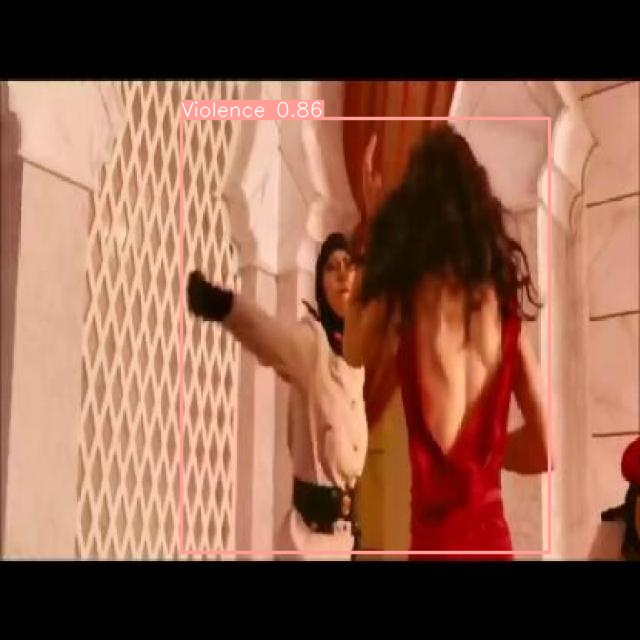

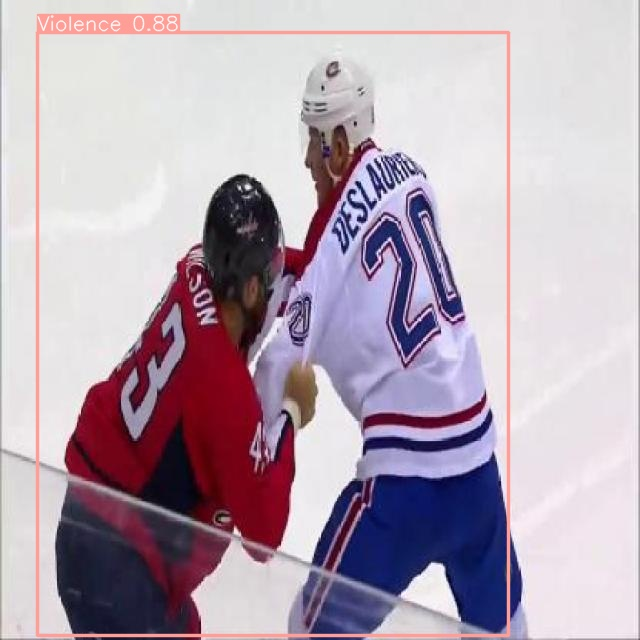

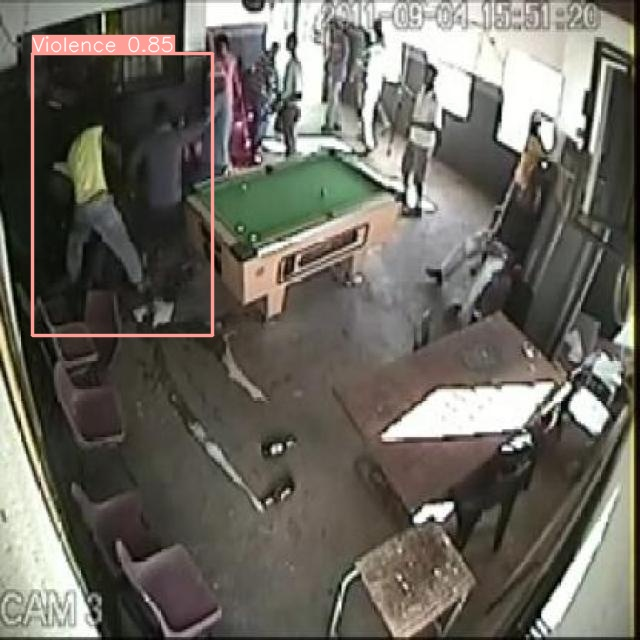

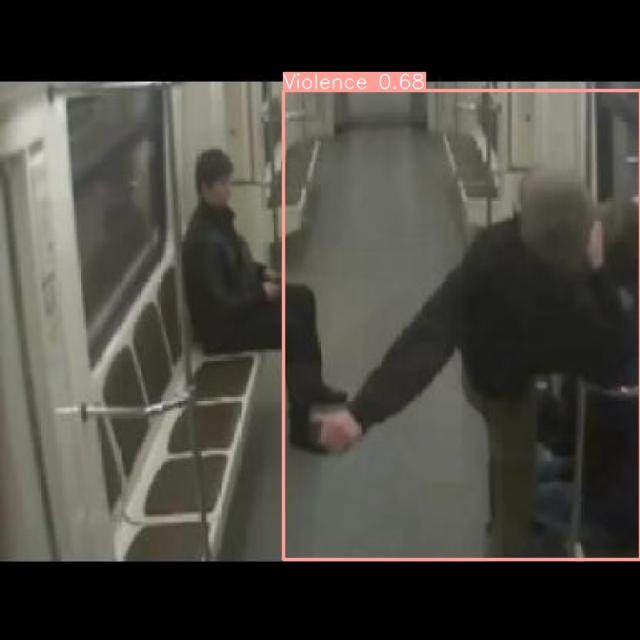

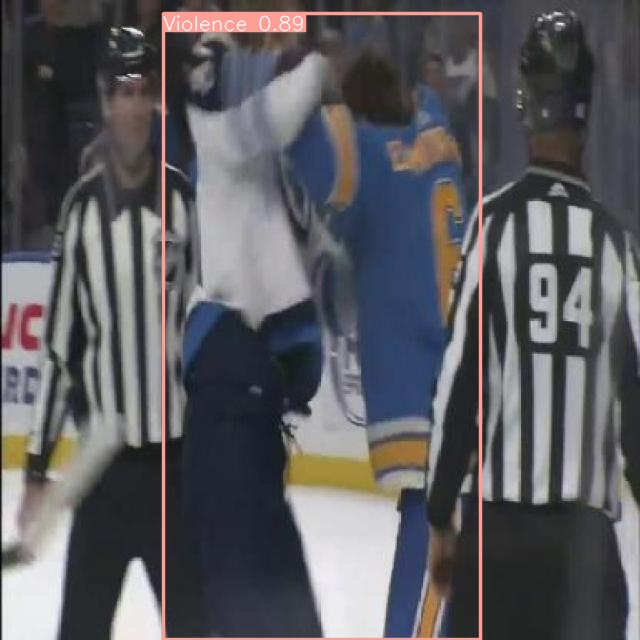

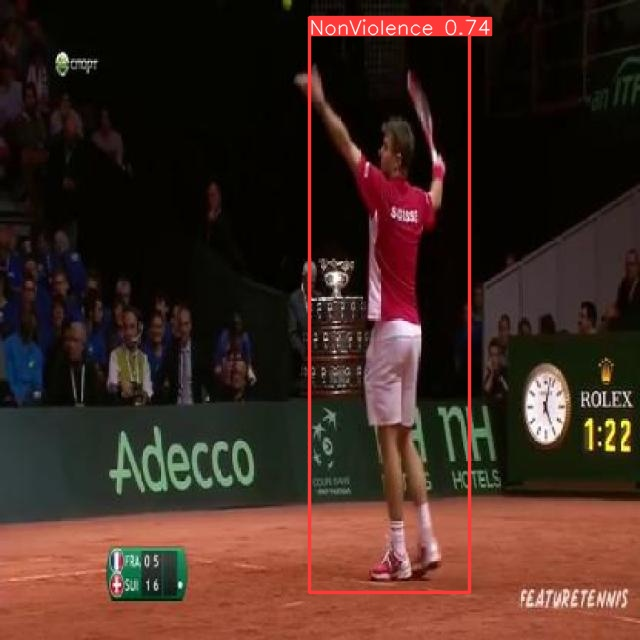

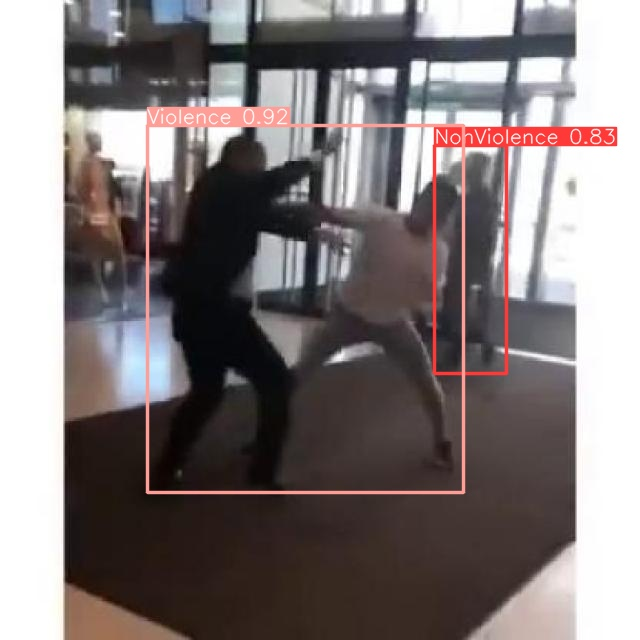

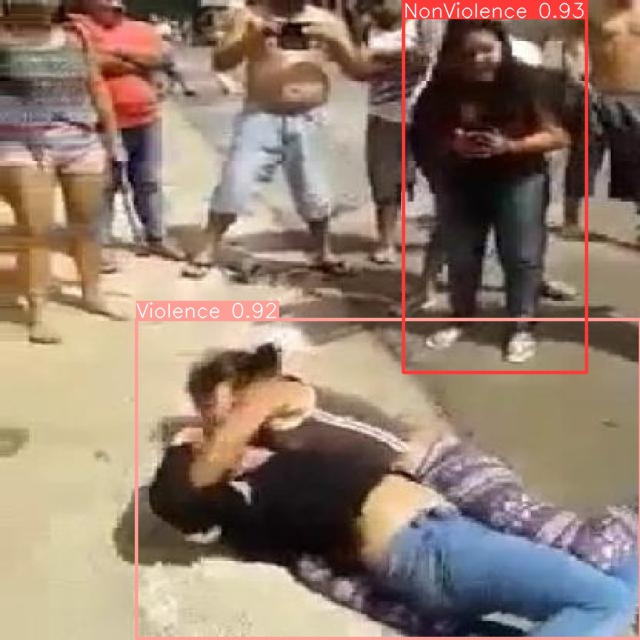

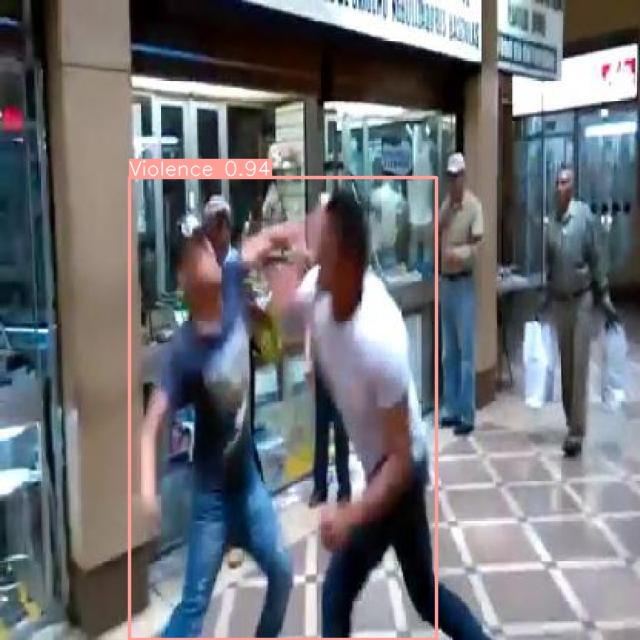

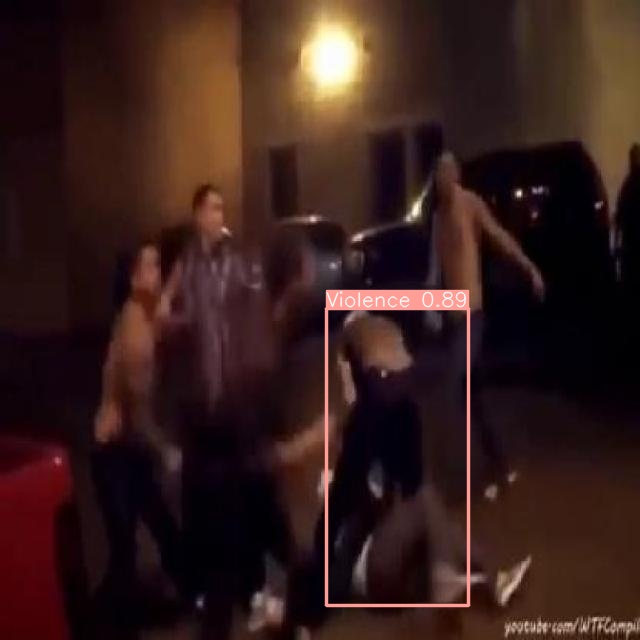

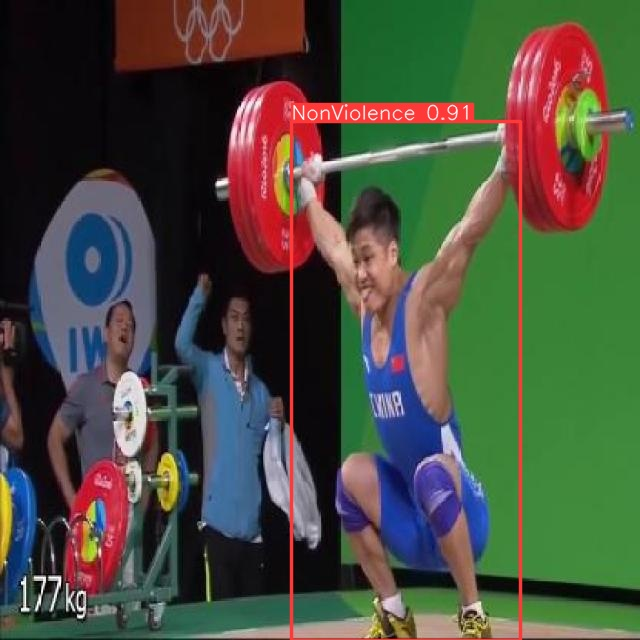

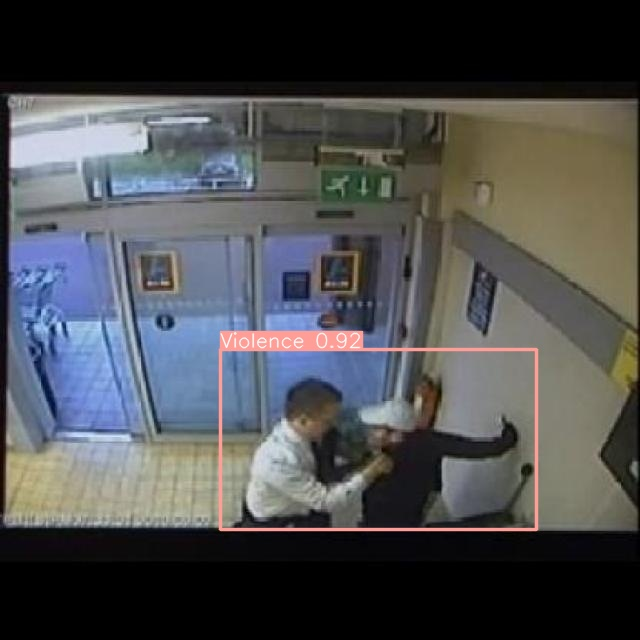

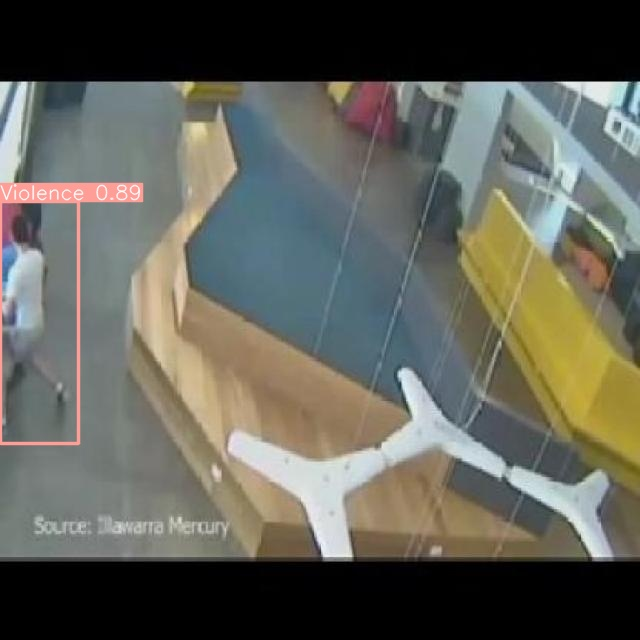

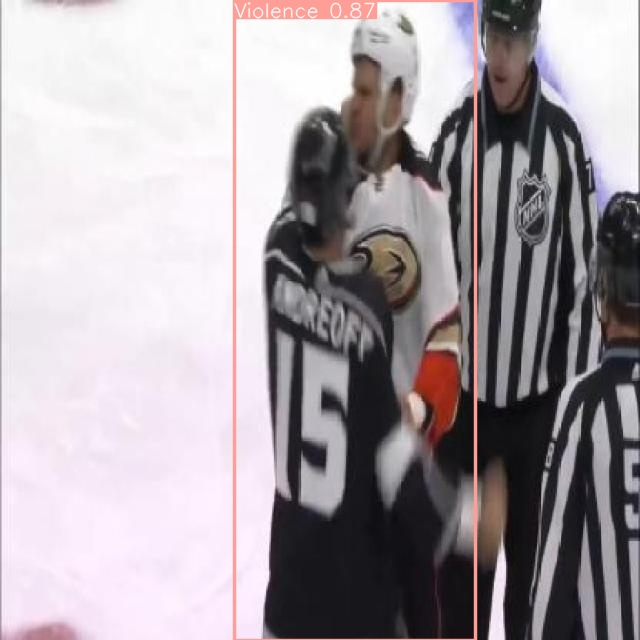

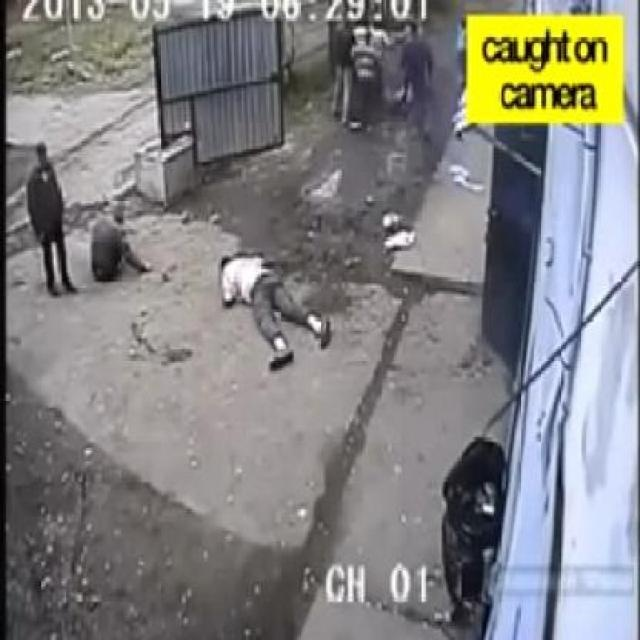

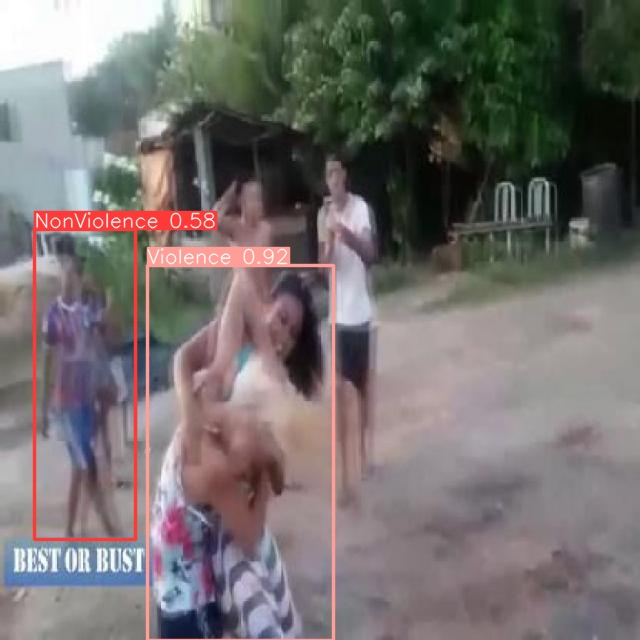

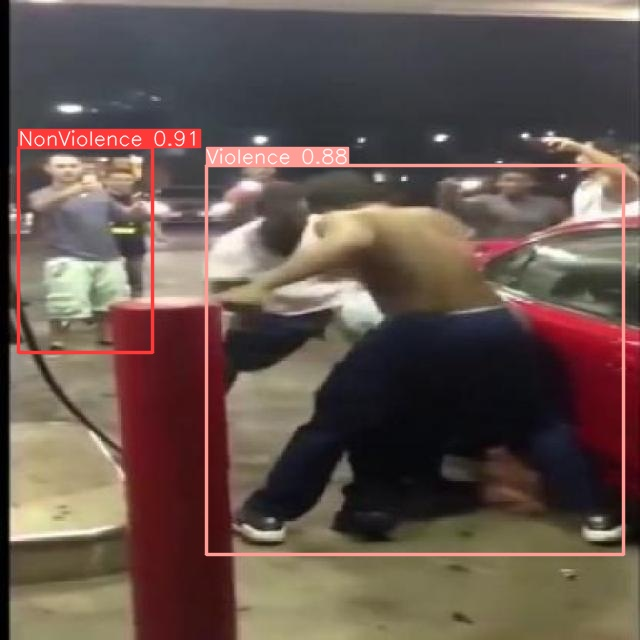

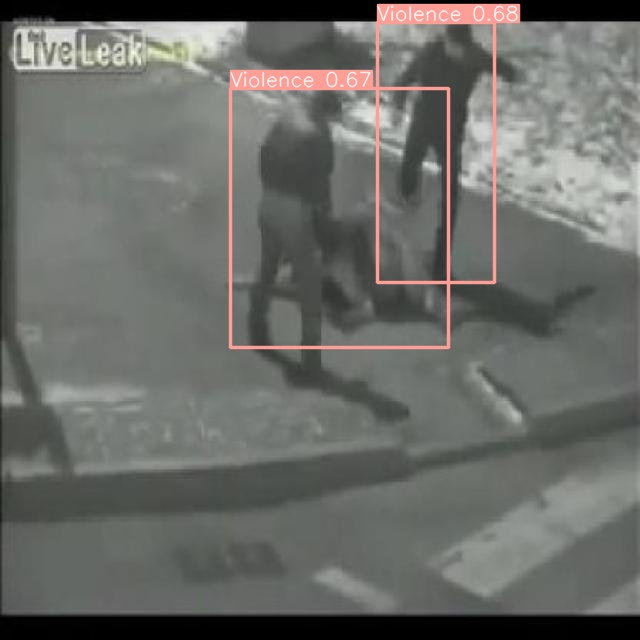

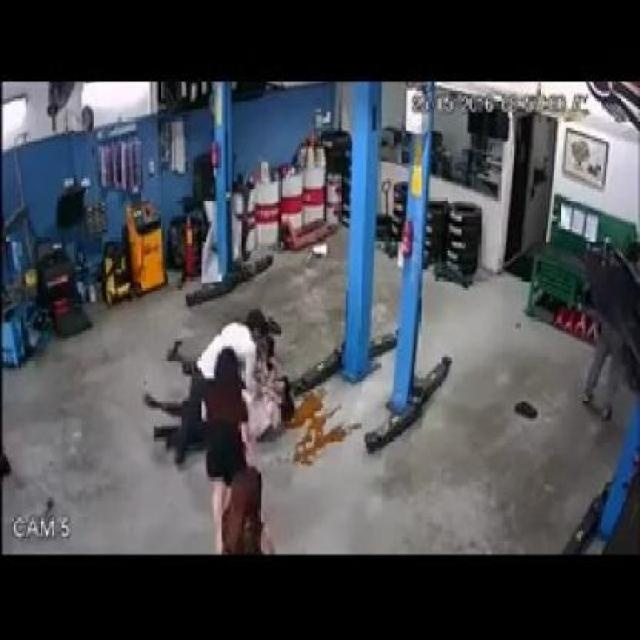

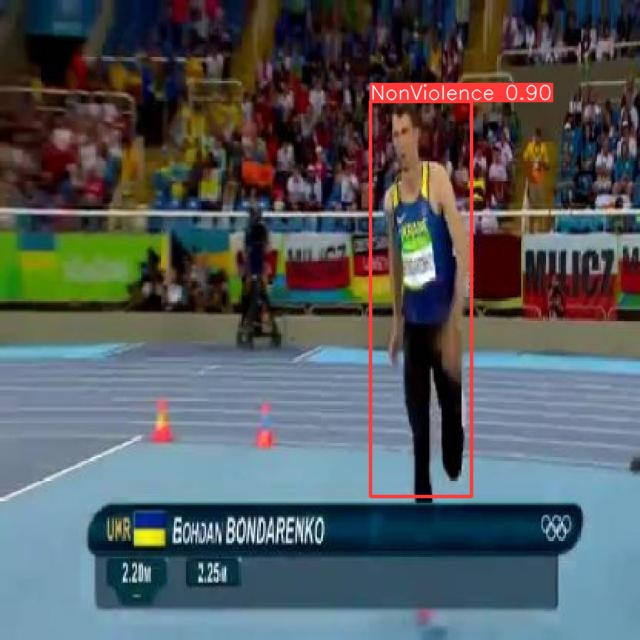

In [39]:
from IPython.display import Image, display
import glob

# Assuming you have defined the HOME variable
# HOME = '/path/to/home/directory'

image_paths = glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[:20]

for image_path in image_paths:
    display(Image(filename=image_path, width=400))
    print("\n")

#### Export Yolov8 model :

In [36]:
%cd {HOME}

/content


In [37]:
# Export the model
model.export(format='onnx')

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train2/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (21.5 MB)

ONNX: starting export with onnx 1.14.1 opset 17...
ONNX: export success ✅ 2.2s, saved as 'runs/detect/train2/weights/best.onnx' (42.6 MB)

Export complete (4.6s)
Results saved to /content/runs/detect/train2/weights
Predict:         yolo predict task=detect model=runs/detect/train2/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train2/weights/best.onnx imgsz=640 data=/content/yolo_datasets/violence-1/data.yaml  
Visualize:       https://netron.app


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



'runs/detect/train2/weights/best.onnx'